In [1]:
#=======================================================================================================================

#Publication Version - Relative Risk Climatology and Visualization Code

#Sean Ernst and Makenzie Krocak

#August 16, 2024

#V1.0

#=======================================================================================================================

In [1]:
import numpy as np
import scipy.ndimage.filters as gauss
import scipy.spatial
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import datetime
%matplotlib inline
from tempfile import TemporaryFile
from pylab import rcParams
rcParams['figure.figsize'] = (10,8)  
import matplotlib.colors as colors
import xarray as xr
from dateutil.rrule import rrule, DAILY
from matplotlib.ticker import LogFormatter
import geopandas as gpd
from rasterio.features import geometry_mask
from scipy.stats import beta
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import regionmask

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from matplotlib.pyplot import figure
import collections
import math
import csv

import shapely as shp
from shapely import geometry
from matplotlib import cm
import fiona
import os,json
from descartes.patch import PolygonPatch

from pathlib import Path

#==============================================================================================
#Inputs for output plots:
#define dataset length - currently 1950 - 2022
startyear = 1950
endyear = 2022

#Climatology length by start and end year
climoend = 2022
climostart = 1950 

#Plot Date - chooses test day that will have absolute, climo, and relative risks plotted:
pyear = 2021
pmonth = 12
pday = 15

#Point of Interest lat/lon - for local relative risk calculation
plat = 45
plon = -93

In [2]:
#Data input and wrangling - note that the read.csv destination must be edited for your PC!

lats_deg=[]
lons_deg=[]
rtime=[]
tor_EF=[]

#Reads in dataset (tornado reports) values for date, start lat/lon, and strength for tornadoes.
df = pd.read_csv(#INPUT - TORNADO REPORT DATASET LOCATION#, header = 0)
lats_deg1 = df['slat'].values
lons_deg1 = df['slon'].values
yyyymmdd1 = df['date'].values
hhmmss1 = df['time'].values
tor_EF=df['mag'].values
year1=startyear
year2=endyear
month=1
day=1
total_years = np.arange(year1,year2)
year_days = 366
start_day=datetime.datetime(year1, month, day, 12, 0)
end_day=datetime.datetime(year2, month, day, 12, 0)

#Adjusts times to Z based on all times being in CST.
dts1 = [datetime.datetime.strptime(d+' '+t, '%Y-%m-%d %H:%M:%S') + datetime.timedelta(hours=6) for d,t in zip(yyyymmdd1, hhmmss1)]

#creates a grid of points across the projection.
fig = figure()
ax_lcc = fig.add_subplot(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=39.8, 
                                                            standard_parallels=(39.8,39.8)))

xmin, ymin = ax_lcc.projection.transform_point(-121.04, 20.5,ccrs.Geodetic())
xmax, ymax = ax_lcc.projection.transform_point(-59.80, 48.30,ccrs.Geodetic())
dx = dy = 80*1000.
plt.close()

xaxis = np.arange(xmin, xmax+1, dx).tolist()
yaxis = np.arange(ymin, ymax+1, dy).tolist()
XX, YY = np.meshgrid(xaxis, yaxis)
griddata=list(zip(XX.flatten(),YY.flatten())) #Note KDTree needs a list to run properly

#Defines a tree item based on the defined gridpoints
tree = scipy.spatial.KDTree(griddata)

#Limits sample to time range and >= EF1 tornadoes.  EF0 reports are incredibly frequent and reporting varies by WFO.
for k in range(len(dts1)):
    if dts1[k] >= start_day and dts1[k] <= end_day and tor_EF[k]>=1:
            lats_deg.append(lats_deg1[k])
            lons_deg.append(lons_deg1[k])
            rtime.append(dts1[k])

grid_year = []
daily_grids = []

#Begins loop that assigns lat and lon values onto the previously defined grid, then assigns 1 or 0 value to grid boxes
#Based on whether or not a report was present in that gridbox
for k in range(len(total_years)):
    yearlats = []
    yearlons = []
    reptime = []
    yearbeg = total_years[k]
    yearend = total_years[k] + 1
    start_yr=datetime.datetime(yearbeg, month, day, 12, 0)
    end_yr=datetime.datetime(yearend, month, day, 12, 0)
    for j in range(len(rtime)):
        if rtime[j] >= start_yr and rtime[j] <= end_yr:
            yearlats.append(lats_deg[j])
            yearlons.append(lons_deg[j])
            reptime.append(rtime[j]) 
    
    xpt=[]
    ypt=[]
    inds=[]
    xind=[]
    yind=[]

    #Converts lons and lats for reports to geodetic points
    conv = [ax_lcc.projection.transform_point(a,b,ccrs.Geodetic()) for a, b in zip(yearlons, yearlats)]
    for i in range(len(conv)):
        point = conv[i]
        xpt.append(point[0])
        ypt.append(point[1])

    #Identifies nearest gridpoint to report lats and lons using tree.query 
    for h in range(len(yearlons)):
        distance, index = tree.query(np.array([[xpt[h],ypt[h]]]))
        inds.append(index)

    #Assigns 0 and 1 values to grids based on presence of a tornado start point
    griddata = np.array(griddata)
    for p in range(len(inds)):
        point=griddata[inds[p]]
        point=point[0]
        xnum=point[0]
        ynum=point[1]
        xind.append(xaxis.index(xnum))
        yind.append(yaxis.index(ynum))

    start_hour=datetime.datetime(yearbeg, 1, 1, 12, 0)

    gpdays=np.zeros((year_days,len(yaxis),len(xaxis)))

    #Creates an array of grid values for each day of the year for all the years in the dataset.
    for m in range(len(xind)):
        x1=xind[m]
        y1=yind[m]
    
        dur=reptime[m]-start_hour
        seconds=dur.total_seconds()
        z1=int(seconds//(3600*24))
        gpdays[z1,y1,x1]=1
    
    grid_year.append(yearbeg)
    daily_grids.append(gpdays)
    print('Yes! '+str(yearbeg))
    
print("Done!")


Yes! 1950
Yes! 1951
Yes! 1952
Yes! 1953
Yes! 1954
Yes! 1955
Yes! 1956
Yes! 1957
Yes! 1958
Yes! 1959
Yes! 1960
Yes! 1961
Yes! 1962
Yes! 1963
Yes! 1964
Yes! 1965
Yes! 1966
Yes! 1967
Yes! 1968
Yes! 1969
Yes! 1970
Yes! 1971
Yes! 1972
Yes! 1973
Yes! 1974
Yes! 1975
Yes! 1976
Yes! 1977
Yes! 1978
Yes! 1979
Yes! 1980
Yes! 1981
Yes! 1982
Yes! 1983
Yes! 1984
Yes! 1985
Yes! 1986
Yes! 1987
Yes! 1988
Yes! 1989
Yes! 1990
Yes! 1991
Yes! 1992
Yes! 1993
Yes! 1994
Yes! 1995
Yes! 1996
Yes! 1997
Yes! 1998
Yes! 1999
Yes! 2000
Yes! 2001
Yes! 2002
Yes! 2003
Yes! 2004
Yes! 2005
Yes! 2006
Yes! 2007
Yes! 2008
Yes! 2009
Yes! 2010
Yes! 2011
Yes! 2012
Yes! 2013
Yes! 2014
Yes! 2015
Yes! 2016
Yes! 2017
Yes! 2018
Yes! 2019
Yes! 2020
Yes! 2021
Done!


In [3]:
#Spatial and Temporal smoothing code!
#Assigns spatial and temporal smoothing values and then smoothes grids

#Sets total number of days in the 3 year smoothing array
total_days=1100

#Standard is 1.5 for ~25 mile probs
# try 3 or 1, as well as maybe 7/30 for days, to see how lists change
sig_spatial=1.5 
sig_daily=15

smooth_grids = []

#Creates array with year being smoothed repeated three times - for temporal smoothing purposes.
for k in range(len(daily_grids)):
    yeartry = daily_grids[k]
    year_smoother=np.zeros((1100,45,66))
    year_smoother[0:366,:,:]=yeartry
    year_smoother[367:733,:,:]=yeartry
    year_smoother[734:1100,:,:]=yeartry

    print("start:",(k + 1950),",",year_smoother.max())
    
    #smooth spatially by day
    for j in range(total_days):
        smooth_day=gauss.gaussian_filter(year_smoother[j,:,:],sig_spatial)
        year_smoother[j,:,:]=smooth_day
    
    print('after spatial: ', year_smoother.max())
    
    #smooth across 15 days around day in question
    for m in range(45):
        for n in range(66):
            smooth_point=gauss.gaussian_filter1d(year_smoother[:,m,n],sig_daily)
            year_smoother[:,m,n]=smooth_point
    print('after daily: ',year_smoother.max())

    #Appends copy of the year being smoothed from the middle of the array of copies
    smooth_grids.append(year_smoother[367:733,:,:])
    
print("end!")


start: 1950 , 1.0
after spatial:  0.3019526076868071


C:\Users\smoke\AppData\Local\Temp\ipykernel_21068\800946513.py:26: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth_day=gauss.gaussian_filter(year_smoother[j,:,:],sig_spatial)
C:\Users\smoke\AppData\Local\Temp\ipykernel_21068\800946513.py:34: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth_point=gauss.gaussian_filter1d(year_smoother[:,m,n],sig_daily)


after daily:  0.016342291762554684
start: 1951 , 1.0
after spatial:  0.1903660715234566
after daily:  0.016182829020593276
start: 1952 , 1.0
after spatial:  0.4232453421836627
after daily:  0.01250242152905453
start: 1953 , 1.0
after spatial:  0.3999614873241844
after daily:  0.015680408034410957
start: 1954 , 1.0
after spatial:  0.5224321716867015
after daily:  0.02456230191382399
start: 1955 , 1.0
after spatial:  0.3775391236992356
after daily:  0.0323139780968905
start: 1956 , 1.0
after spatial:  0.4133430023011873
after daily:  0.01596166123714206
start: 1957 , 1.0
after spatial:  0.5118722045685565
after daily:  0.02222246055873671
start: 1958 , 1.0
after spatial:  0.43124515241259576
after daily:  0.019151917213567994
start: 1959 , 1.0
after spatial:  0.407424290402584
after daily:  0.027039300215758663
start: 1960 , 1.0
after spatial:  0.5627819044838032
after daily:  0.033175881301103605
start: 1961 , 1.0
after spatial:  0.5029096483912814
after daily:  0.02152715117219742
star

In [51]:
#Smoothing code for daily reports - same as previous cell but removes temporal smoothing to focus on single day reports.
total_days=1100

#Standard is 1.5 for ~25 mile probs
sig_spatial=1.5

Spatial_grids = []

for k in range(len(daily_grids)):
    yeartry = daily_grids[k]
    year_smoother=np.zeros((1100,45,66))
    year_smoother[0:366,:,:]=yeartry
    year_smoother[367:733,:,:]=yeartry
    year_smoother[734:1100,:,:]=yeartry

    print("start:",(k + 1950),",",year_smoother.max())
    
    #smooth spatially by day
    for j in range(total_days):
        smooth_day=gauss.gaussian_filter(year_smoother[j,:,:],sig_spatial)
        year_smoother[j,:,:]=smooth_day
    
    print('after spatial: ', year_smoother.max())
    
    Spatial_grids.append(year_smoother[367:733,:,:])
    
print("end!")


start: 1950 , 1.0
after spatial:  0.3019526076868071
start: 1951 , 1.0
after spatial:  0.1903660715234566
start: 1952 , 1.0
after spatial:  0.4232453421836627
start: 1953 , 1.0


C:\Users\smoke\AppData\Local\Temp\ipykernel_11184\3337294283.py:20: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth_day=gauss.gaussian_filter(year_smoother[j,:,:],sig_spatial)


after spatial:  0.3999614873241844
start: 1954 , 1.0
after spatial:  0.5224321716867015
start: 1955 , 1.0
after spatial:  0.3775391236992356
start: 1956 , 1.0
after spatial:  0.4133430023011873
start: 1957 , 1.0
after spatial:  0.5118722045685565
start: 1958 , 1.0
after spatial:  0.43124515241259576
start: 1959 , 1.0
after spatial:  0.407424290402584
start: 1960 , 1.0
after spatial:  0.5627819044838032
start: 1961 , 1.0
after spatial:  0.5029096483912814
start: 1962 , 1.0
after spatial:  0.32160593001204324
start: 1963 , 1.0
after spatial:  0.4876154029549052
start: 1964 , 1.0
after spatial:  0.3592728679407603
start: 1965 , 1.0
after spatial:  0.5835856635714545
start: 1966 , 1.0
after spatial:  0.378394055219988
start: 1967 , 1.0
after spatial:  0.5601724696153866
start: 1968 , 1.0
after spatial:  0.40895988772962544
start: 1969 , 1.0
after spatial:  0.38227433150301016
start: 1970 , 1.0
after spatial:  0.4463571121980145
start: 1971 , 1.0
after spatial:  0.4238218452754995
start: 19

In [54]:
#Climatology Calculation

#Create XArray for easy climatology calculation + compilation of daily grids
yeardays = [*range(1,367,1)]

raw_grids = xr.Dataset(data_vars = dict(smooth_torprobs=(["year","day","lat","lon"], smooth_grids)
                                   ), 
                  coords = dict(year = (["year"], grid_year),
                                day = (["day"], yeardays),
                                lat = (["lat"], yaxis),
                                lon = (["lon"], xaxis)
                               ))

#Slices array for years to be used in climatology, then calculate means for each gridpoint on each day.
climoset = raw_grids.sel(year=slice(climostart,climoend))

DailyClimo = climoset.mean(dim = ['year'])

#Mask values outside of the US - uses US shapefile from the census bureau and the Regionmask package
USshp = gpd.read_file(r"C:\Users\smoke\Documents\CRCM research\PhD Dissertation\Climo work/cb_2018_us_nation_20m/cb_2018_us_nation_20m.shp")

#Converts shapefile to LCC coords that match coords of dataset
USshp = USshp.to_crs({'proj': 'lcc', 'lat_1': 39.8, 'lat_2': 39.8, 'lat_0': 39.8, 'lon_0': -100, 'x_0': 0, 'y_0': 0,
                      'datum': 'WGS84', 'units': 'm', 'no_defs': True})

xmin, ymin = ax_lcc.projection.transform_point(-121.04, 20.5,ccrs.Geodetic())
xmax, ymax = ax_lcc.projection.transform_point(-59.80, 48.30,ccrs.Geodetic())
dx = dy = 80*1000.
xaxis = np.arange(xmin, xmax+1, dx).tolist()
yaxis = np.arange(ymin, ymax+1, dy).tolist()

#Create XArray for smoothed daily tornado occurrence *without time smoothing*
yeardays = [*range(1,367,1)]
Day_grids = xr.Dataset(data_vars = dict(smooth_torprobs=(["year","day","lat","lon"], Spatial_grids)
                                   ), 
                  coords = dict(year = (["year"], grid_year),
                                day = (["day"], yeardays),
                                lat = (["lat"], yaxis),
                                lon = (["lon"], xaxis)
                               ))

#Creates mask of the lower 48 at the same LCC grid spacing as the dataset
USbounds = regionmask.mask_geopandas(USshp, xaxis, yaxis, wrap_lon = False)

#Mask daily probabilities below a specified value:
#Consider not calculating Nromalized risk below X value - single report suggests below 0.08 (explore 0.02 to line with spc)
Day_grids = Day_grids.where((Day_grids.smooth_torprobs >= 0.02))
Day_gridsMa = Day_grids.where(USbounds == False)

#Relative Risk Grid Construction - uses spatial smoothed grids by day divided by climo
RelRisk = (Day_grids / DailyClimo)
RelRisk = RelRisk.rename({'smooth_torprobs' : 'RelRisks'})

#Masks all gridpoints outside of the US in the relative risk dataset (for ranking purposes).
RelRiskMa = RelRisk.where(USbounds == False)

In [56]:
#Plot Date - chooses test day that will have absolute, climo, and relative risks plotted:
pyear = 2019
pmonth = 5
pday = 20

#Plot location - chooses location for creating histogram/exceedance plot
plat = 37
plon = -88.5

#some fun little statistics
np.max(DailyClimo.where(USbounds == False).smooth_torprobs * 100)

<xarray.DataArray 'smooth_torprobs' ()>
array(0.87944329)

37.44566912862841


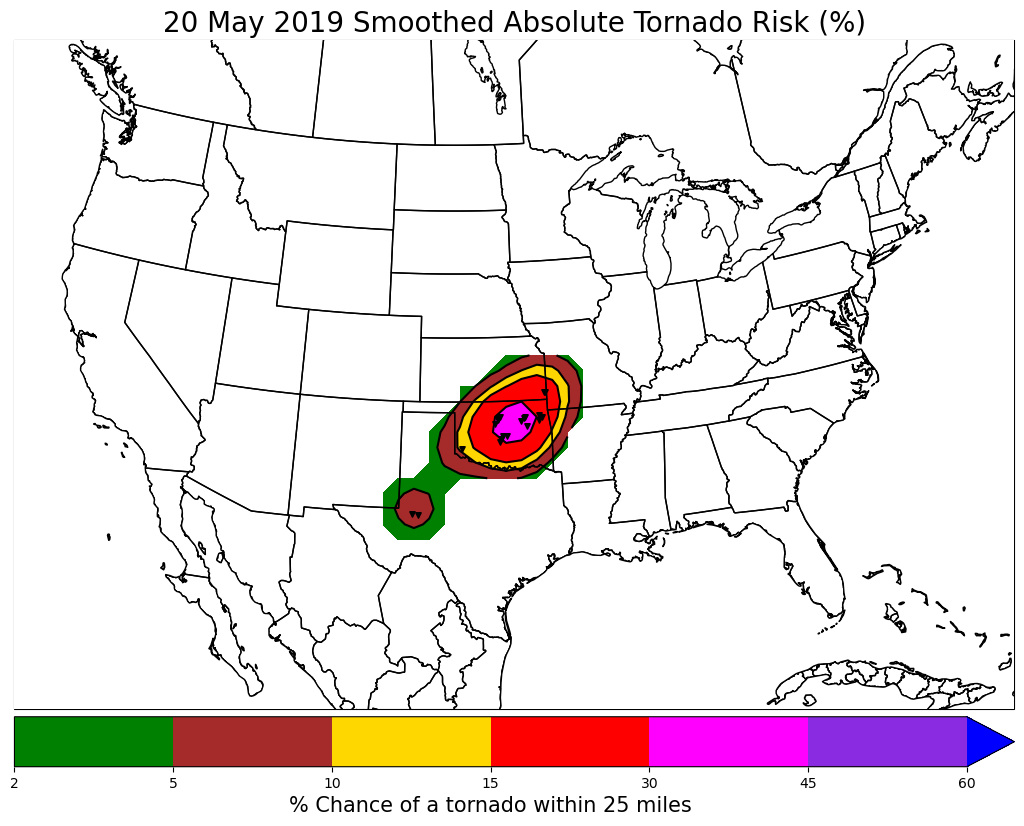

In [8]:
#PLOT OUTPUT for spatially smoothed report grids

year=pyear
month=pmonth
day=pday

day=datetime.datetime(year, month, day, 12, 0)
dayofyear = day.timetuple().tm_yday

DayAbs = Day_grids.sel(year=pyear,day=dayofyear).smooth_torprobs

fig = plt.figure()
ax_lcc = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(central_longitude=-100,central_latitude=39.8,
                                                                    standard_parallels=(39.8,39.8)))

ax_lcc.set_extent([-121.04, -73.1, 20.5, 51.3], ccrs.Geodetic())
ax_lcc.coastlines(resolution='10m')
ax_lcc.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
ax_lcc.add_feature(cfeature.STATES.with_scale('10m'), zorder = 99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        ax_lcc.add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=50)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        ax_lcc.add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    else:
        pass  #do not plot the geometry    

col=colors.ListedColormap(["green","brown","gold","red","fuchsia","blueviolet","blue"])
v = [2,5,10,15,30,45,60,70]
norm = colors.BoundaryNorm(v, col.N)

plt.contour(XX,YY,(DayAbs * 100),levels=v[0:7], colors = "black", norm = norm)
plt.contourf(XX,YY,(DayAbs * 100),cmap=col,vmin=0, levels=v[0:7], norm = norm, extend = "max",zorder = 0)

cbar=plt.colorbar(orientation='horizontal', pad=0.01)
cbar.set_label('% Chance of a tornado within 25 miles', size = 15)
date = day.strftime('%d %b %Y')
plt.title('{} Smoothed Absolute Tornado Risk (%)'.format(date),size=20)

lats_deg27=[]
lons_deg27=[]
for k in range(len(rtime)):
        if rtime[k] >= day and rtime[k] <= (day + datetime.timedelta(days=1)):
            lats_deg27.append(lats_deg[k])
            lons_deg27.append(lons_deg[k])
plt.scatter(x=lons_deg27, y=lats_deg27,
            color="black",
            s = 15,
            marker = "v",
            transform=ccrs.PlateCarree()) ## Important
print(float(np.max(DayAbs*100)))

Text(0.5, 1.0, '20 May Climatological Risk of Tornadoes (%)')

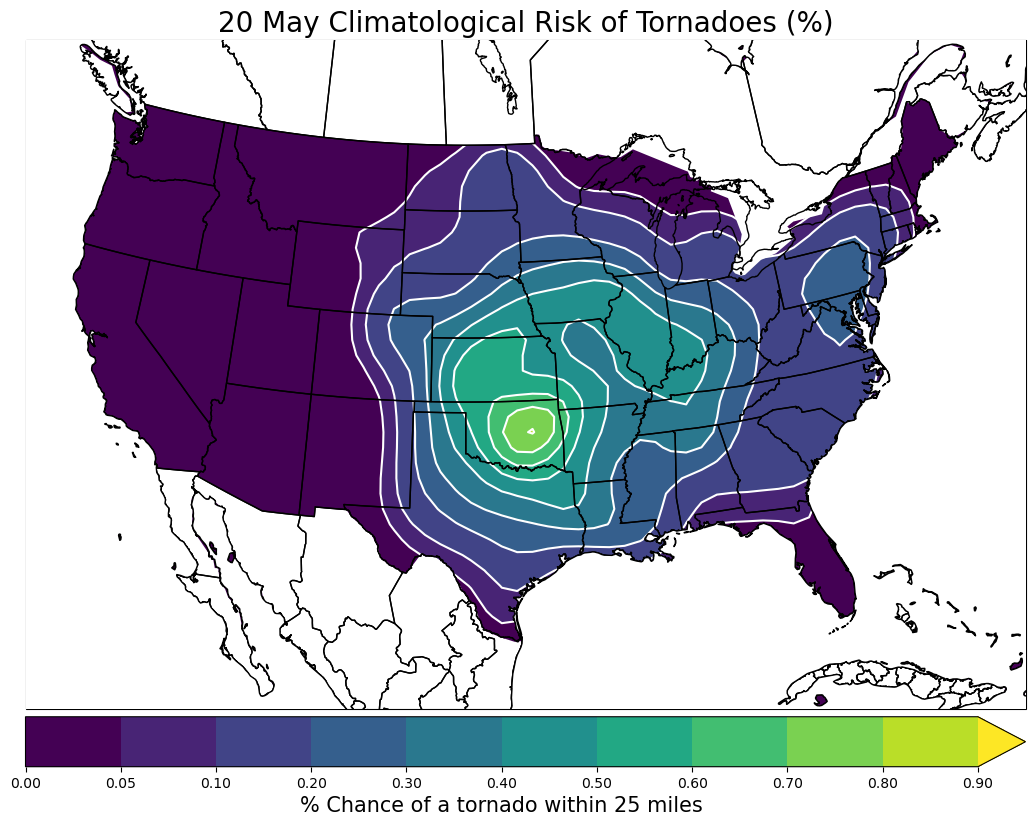

In [57]:
#PLOT OUTPUT for spatiotemporally smoothed climo grids

year=pyear
month=pmonth
day=pday

day=datetime.datetime(year, month, day, 12, 0)
dayofyear = day.timetuple().tm_yday

DayCli = DailyClimo.sel(day=dayofyear).smooth_torprobs

fig = plt.figure()
ax_lcc = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(central_longitude=-100,central_latitude=39.8,
                                                                    standard_parallels=(39.8,39.8)))

ax_lcc.set_extent([-121.04, -73.1, 20.5, 51.3], ccrs.Geodetic())
ax_lcc.coastlines(resolution='10m')
ax_lcc.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
ax_lcc.add_feature(cfeature.STATES.with_scale('10m'), zorder = 99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        ax_lcc.add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=50)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        ax_lcc.add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    else:
        pass  #do not plot the geometry    

#Plot data
col = plt.cm.viridis  # define the colormap
v = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
norm = colors.BoundaryNorm(v, col.N)

plt.contour(XX,YY,(DayCli * 100),colors = "white", levels=v[1:11], norm = norm)
plt.contourf(XX,YY,(DayCli * 100),cmap=col,vmin=0,vmax=0.9, extend = "max",levels=v[0:11], norm = norm, zorder = 0)

cbar=plt.colorbar(ticks = v[0:11], orientation='horizontal', pad=0.01)
cbar.set_label('% Chance of a tornado within 25 miles', size = 15)
date = day.strftime('%d %b')
plt.title('{} Climatological Risk of Tornadoes (%)'.format(date),size=20)

Text(0.5, 1.0, '20 May 2019 Relative Risk of Tornadoes')

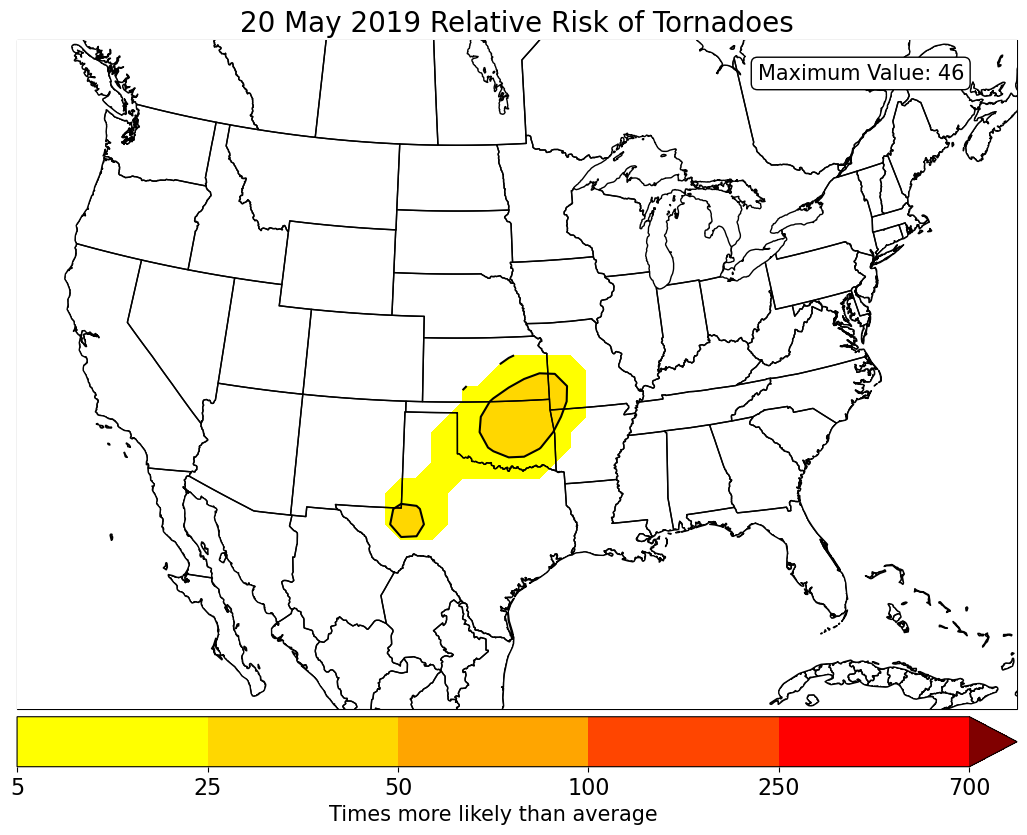

In [11]:
#PLOT OUTPUT for relative risk grids

year=pyear
month=pmonth
day1=pday

day=datetime.datetime(year, month, day1, 12, 0)
dayofyear = day.timetuple().tm_yday

DayRisk = RelRisk.sel(year=pyear,day=dayofyear).RelRisks

fig = plt.figure()
ax_lcc = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(central_longitude=-100,central_latitude=39.8,
                                                                    standard_parallels=(39.8,39.8)))

ax_lcc.set_extent([-121.04, -73.1, 20.5, 51.3], ccrs.Geodetic())
ax_lcc.coastlines(resolution='10m')
ax_lcc.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
ax_lcc.add_feature(cfeature.STATES.with_scale('10m'), zorder = 99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        ax_lcc.add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=50)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        ax_lcc.add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    else:
        pass  #do not plot the geometry    

#col=colors.ListedColormap(["green","brown","yellow","gold","orange","red","crimson","fuchsia"]) - og colors
col=colors.ListedColormap(["yellow","gold","orange","orangered","red","maroon"])
#v= [5,20,50,100,250,500,750,1000,1250] - original colorbar, numbers too high
#v = [5,10,25, 50, 75,100,250, 500, 750] - second colorbar, revised with CDF information
v = [5,25,50,100,250,700,2000]
norm = colors.BoundaryNorm(v, col.N)

plt.contour(XX,YY,DayRisk,colors = "black", levels=v[0:6], norm = norm)
plt.contourf(XX,YY,DayRisk, cmap=col,vmin=0, levels=v[0:6], norm = norm, extend = "max",zorder = 0)
cbar=plt.colorbar(ticks = v[0:6], orientation='horizontal', pad=0.01)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Times more likely than average', size = 15)

#if np.max(DayRisk) > 1000: #Adds hatching for extreme values over 1000
#    plt.contourf(XX,YY,DayRisk, levels=[np.min(DayRisk),1000,np.max(DayRisk)], colors='none',
#                      hatches=[None,'xx',],
#                      extend='max')

date = day.strftime('%d %b %Y')

plt.text(
    2100000,1400000, "Maximum Value: {}".format(int(np.max(RelRiskMa.sel(year=pyear,day=dayofyear).RelRisks))), ha="center", va="center", size=15,
    bbox=dict(boxstyle="round,pad=0.3", fc = "white"), zorder = 100)

plt.title('{} Relative Risk of Tornadoes'.format(date),size=20)

#Add point that displays location of histogram
#plt.scatter(x=plon, y=plat,color="black", s = 100, transform=ccrs.PlateCarree())

#Plots tornado reports===============================================================================
#start_day=datetime.datetime(year, month, day1, 12, 0)
#end_day=start_day + datetime.timedelta(days = 1)
#lats_deg27=[]
#lons_deg27=[]
#for k in range(len(rtime)):
#        if rtime[k] >= start_day and rtime[k] <= end_day:
#            lats_deg27.append(lats_deg[k])
#            lons_deg27.append(lons_deg[k])
#plt.scatter(x=lons_deg27, y=lats_deg27,
#            color="black",
#            s = 2,
#            transform=ccrs.PlateCarree()) ## Important



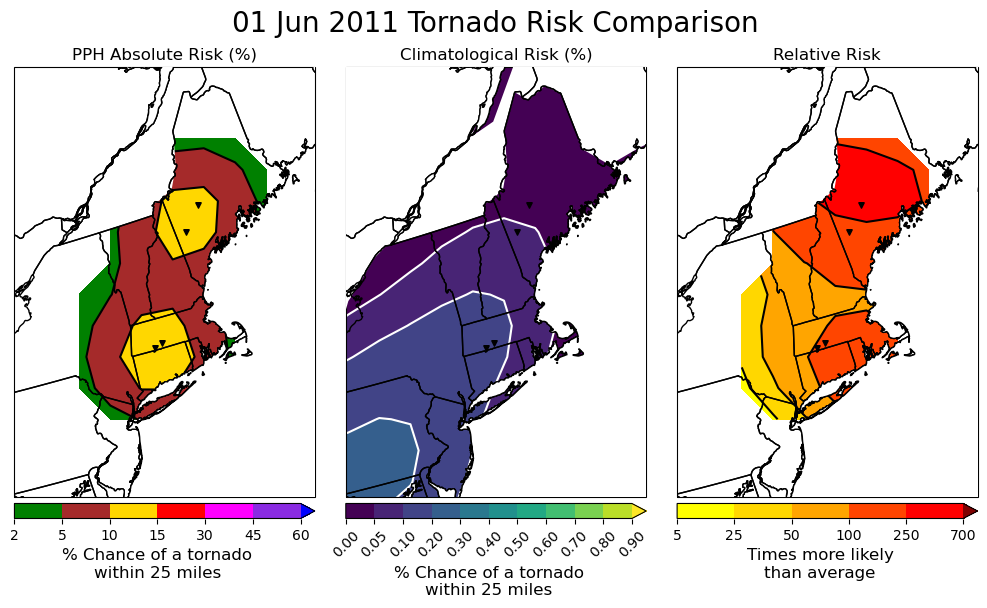

In [9]:
#Absolute vs Climo vs Relative plots - horizontal separation, lat-lon zoom

year= pyear
month= pmonth
pday= pday

#SETS BOUNDS OF PLOT, MANUAL EDIT ===========================================================================
MaxW = -75
MinE = -69
MaxN = 48
MinS = 39

header = 0.85
final = True

#============================================================================================================

day=datetime.datetime(year, month, pday, 12, 0)
dayofyear = day.timetuple().tm_yday

DayAbs = Day_grids.sel(year=year,day=dayofyear).smooth_torprobs
DayRisk = RelRisk.sel(year=year,day=dayofyear).RelRisks
DayCli = DailyClimo.sel(day=dayofyear).smooth_torprobs * 100

fig, axs = plt.subplots(ncols=3, subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-100,central_latitude=39.8,
                                                                    standard_parallels=(39.8,39.8))})

date = day.strftime('%d %b %Y')
fig.suptitle('{} Tornado Risk Comparison'.format(date), size = 20, y = header #Set table header position with y
            )

#AX1=============================================================================================================
axs[0].set_extent([MaxW, MinE, MinS, MaxN], ccrs.Geodetic())
axs[0].coastlines(resolution='10m')
axs[0].add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
axs[0].add_feature(cfeature.STATES.with_scale('10m'), zorder=99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        axs[0].add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        axs[0].add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    else:
        pass  #do not plot the geometry    

col1=colors.ListedColormap(["green","brown","gold","red","fuchsia","blueviolet","blue"])
vabs = [2,5,10,15,30,45,60,70]
norm = colors.BoundaryNorm(vabs, col1.N)

axs[0].contour(XX,YY,(DayAbs * 100),levels=vabs[0:7], colors = "black",norm = norm, zorder = 0.5)
ABC = axs[0].contourf(XX,YY,(DayAbs * 100),cmap=col1,vmin=0, levels=vabs[0:7], norm = norm, extend = "max",zorder = 0)

lats_deg27=[]
lons_deg27=[]
for k in range(len(rtime)):
        if rtime[k] >= day and rtime[k] <= (day + datetime.timedelta(days=1)):
            lats_deg27.append(lats_deg[k])
            lons_deg27.append(lons_deg[k])
axs[0].scatter(x=lons_deg27, y=lats_deg27,
            color="black",
            s = 15,
            marker = "v",
            transform=ccrs.PlateCarree()) ## Important

cbar1=fig.colorbar(ABC, orientation='horizontal', ax = axs[0], pad=0.01)
cbar1.set_label('% Chance of a tornado\nwithin 25 miles', size = 12)
cbar1.ax.tick_params(labelsize=10)
axs[0].set_title('PPH Absolute Risk (%)',size=12)

#AX2=============================================================================================================

axs[1].set_extent([MaxW, MinE, MinS, MaxN], ccrs.Geodetic())
axs[1].coastlines(resolution='10m')
axs[1].add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
axs[1].add_feature(cfeature.STATES.with_scale('10m'), zorder = 99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        axs[1].add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=50)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        axs[1].add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    else:
        pass  #do not plot the geometry    

#Plot data
col=plt.cm.viridis
v = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
norm = colors.BoundaryNorm(v, col.N)

axs[1].contour(XX,YY,(DayCli),colors = "white", levels=v[1:11], norm = norm)
CLI = axs[1].contourf(XX,YY,(DayCli),cmap=col,vmin=0,vmax=0.9, extend = "max",levels=v[0:11], norm = norm, zorder = 0)

axs[1].scatter(x=lons_deg27, y=lats_deg27,
            color="black",
            s = 15,
            marker = "v",
            transform=ccrs.PlateCarree()) ## Important
cbar2=fig.colorbar(CLI, ticks = v[0:11], orientation='horizontal', ax = axs[1], pad=0.01)
cbar2.set_label('% Chance of a tornado\nwithin 25 miles', size = 12)
cbar2.ax.tick_params(labelsize=10,rotation=45)
axs[1].set_title('Climatological Risk (%)'.format(date),size=12)

#AX3=============================================================================================================

axs[2].set_extent([MaxW, MinE, MinS, MaxN], ccrs.Geodetic())
axs[2].coastlines(resolution='10m')
axs[2].add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
axs[2].add_feature(cfeature.STATES.with_scale('10m'), zorder=99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        axs[2].add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        axs[2].add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    else:
        pass  #do not plot the geometry    

col2=colors.ListedColormap(["yellow","gold","orange","orangered","red","maroon"])
vrel = [5,25,50,100,250,700,2000]
norm = colors.BoundaryNorm(vrel, col2.N)

axs[2].contour(XX,YY,DayRisk,levels=vrel[0:6], colors="black", norm = norm, zorder = 0.5)
RLC = axs[2].contourf(XX,YY,DayRisk, cmap=col2,vmin=0, levels=vrel[0:6], norm = norm, extend = "max",zorder = 0)
axs[2].scatter(x=lons_deg27, y=lats_deg27,
            color="black",
            s = 15,
            marker = "v",
            transform=ccrs.PlateCarree()) ## Important
cbar3=fig.colorbar(RLC, ticks = vrel[0:6], orientation='horizontal', pad=0.01)
cbar3.ax.tick_params(labelsize=10)
cbar3.set_label('Times more likely\nthan average', size = 12)
axs[2].set_title('Relative Risk',size=12)

fig.tight_layout(rect=[0, 0.1, 1, 0.95])
if final==True:
    plt.savefig('#OUTPUT FILE DIRECTORY#/{} ThreePanelRiskPlot{}W{}E{}N{}S'.format(date,MaxW,MinE,MaxN,MinS), bbox_inches='tight', dpi = 500)


Text(0.5, 1.0, '10 Dec 2021 Forecast Absolute Tornado Risk (%)')

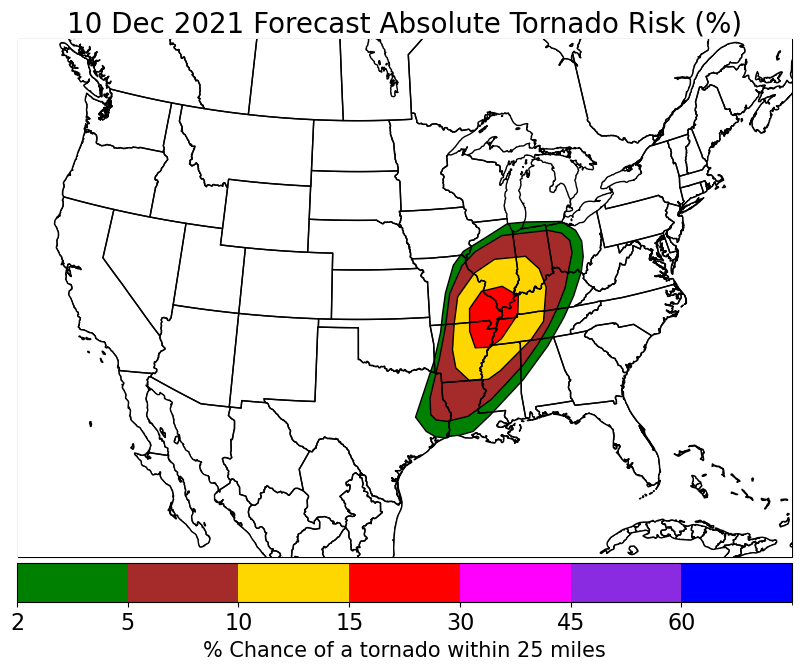

In [7]:
#Code for creating relative risk plots using shapefiles of SPC tornado outlooks
#(shapefile access at https://mesonet.agron.iastate.edu/request/gis/outlooks.phtml)

from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

#IEM Data forecast SPC outlook generator - also exports shapefiles ============================================
Xday = r"#OUTLOOK FILE DIRECTORY#\outlooks_202112100000_202112102300\outlooks_202112100000_202112102300.shp"

issuetimeX = "202112101630" #Issuance YEARMONTHDAYZTIME

#SETS BOUNDS OF PLOT, MANUAL EDIT ===========================================================================
year= 2021
month= 12
pday= 10

SPCoutlook = gpd.read_file(Xday)
issuetime = issuetimeX
W = -121.04
E = -73.1
N = 51.3
S = 20.5
TitleHeight = 0.6

#Automatic code - no edits! =========================================================================================
day=datetime.datetime(year, month, pday, 12, 0)
dayofyear = day.timetuple().tm_yday
DayClim = DailyClimo.sel(day=dayofyear).smooth_torprobs * 100

#Code for stripping SPC outlook shapefiles from IEM download and creating norm risk
#Get files at https://mesonet.agron.iastate.edu/request/gis/spc_outlooks.phtml
SPC2 = SPCoutlook[(SPCoutlook['THRESHOLD'] == '0.02') & (SPCoutlook['CATEGORY'] == 'TORNADO') & (SPCoutlook['ISSUE'] == issuetime)]
SPC5 = SPCoutlook[(SPCoutlook['THRESHOLD'] == '0.05') & (SPCoutlook['CATEGORY'] == 'TORNADO') & (SPCoutlook['ISSUE'] == issuetime)]
SPC10 = SPCoutlook[(SPCoutlook['THRESHOLD'] == '0.10') & (SPCoutlook['CATEGORY'] == 'TORNADO') & (SPCoutlook['ISSUE'] == issuetime)]
SPC15 = SPCoutlook[(SPCoutlook['THRESHOLD'] == '0.15') & (SPCoutlook['CATEGORY'] == 'TORNADO') & (SPCoutlook['ISSUE'] == issuetime)]
SPC30 = SPCoutlook[(SPCoutlook['THRESHOLD'] == '0.30') & (SPCoutlook['CATEGORY'] == 'TORNADO') & (SPCoutlook['ISSUE'] == issuetime)]
SPC45 = SPCoutlook[(SPCoutlook['THRESHOLD'] == '0.45') & (SPCoutlook['CATEGORY'] == 'TORNADO') & (SPCoutlook['ISSUE'] == issuetime)]
SPC60 = SPCoutlook[(SPCoutlook['THRESHOLD'] == '0.60') & (SPCoutlook['CATEGORY'] == 'TORNADO') & (SPCoutlook['ISSUE'] == issuetime)]

SPCSHPS = np.array([SPC2,SPC5,SPC10,SPC15,SPC30,SPC45,SPC60], dtype = object)
SPCvals = np.array([2.,5.,10.,15.,30.,45.,60.])

#Converts shapefile to LCC coords that match coords of dataset
xmin, ymin = ax_lcc.projection.transform_point(-121.04, 20.5,ccrs.Geodetic())
xmax, ymax = ax_lcc.projection.transform_point(-59.80, 48.30,ccrs.Geodetic())
dx = dy = 80*1000.
xaxis = np.arange(xmin, xmax+1, dx).tolist()
yaxis = np.arange(ymin, ymax+1, dy).tolist()

#loops for values
for a in range(len(SPCSHPS)):
    if SPCSHPS[a].is_empty.empty == True: pass
    else: 
        if SPCvals[a] == 2.:
            ARR = SPCSHPS[a]
            Cont = ARR['geometry'].to_crs({'proj': 'lcc', 'lat_1': 39.8, 'lat_2': 39.8, 'lat_0': 39.8, 'lon_0': -100, 'x_0': 0, 'y_0': 0,
                      'datum': 'WGS84', 'units': 'm', 'no_defs': True})
            OTLK = regionmask.mask_3D_geopandas(Cont, xaxis, yaxis, wrap_lon = False).squeeze('region')
            OTLK = OTLK.where(OTLK == False, SPCvals[a])
        else:
            ARR = SPCSHPS[a]
            Cont = ARR['geometry'].to_crs({'proj': 'lcc', 'lat_1': 39.8, 'lat_2': 39.8, 'lat_0': 39.8, 'lon_0': -100, 'x_0': 0, 'y_0': 0,
                        'datum': 'WGS84', 'units': 'm', 'no_defs': True})
            mask = regionmask.mask_3D_geopandas(Cont, xaxis, yaxis, wrap_lon = False).squeeze('region')
            OTLK = OTLK.where(mask == False, SPCvals[a])

FcstNormRisk = (OTLK / DayClim)

#Plotting norm risk with abs risk
fig, axs = plt.subplots(ncols=1, subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-100,central_latitude=39.8,
                                                                    standard_parallels=(39.8,39.8))})
date = day.strftime('%d %b %Y')
axs.set_extent([W,E,S,N], ccrs.Geodetic())
axs.coastlines(resolution='10m')
axs.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
axs.add_feature(cfeature.STATES.with_scale('10m'), zorder=99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        axs.add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=10)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        axs.add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=10)
    else:
        pass  #do not plot the geometry    

col1=colors.ListedColormap(["green","brown","gold","red","fuchsia","blueviolet","blue"])
SPCcolors=np.array(["green","brown","gold","red","fuchsia","blueviolet","blue"])

vabs = [2,5,10,15,30,45,60,100]
norm = colors.BoundaryNorm(vabs, col1.N)

for a in range(len(SPCSHPS)):
    if SPCSHPS[a].is_empty.empty == True: pass
    else:
        ARR = SPCSHPS[a]
        ARR = ARR['geometry'].to_crs({'proj': 'lcc', 'lat_1': 39.8, 'lat_2': 39.8, 'lat_0': 39.8, 'lon_0': -100, 'x_0': 0, 'y_0': 0,
                      'datum': 'WGS84', 'units': 'm', 'no_defs': True})
        ARR.plot(ax=axs, color=SPCcolors[a], edgecolor="black")

cbar1=fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=col1), ticks = vabs[0:7], orientation='horizontal', ax = axs, pad=0.01)
cbar1.set_label('% Chance of a tornado within 25 miles', size = 15)
cbar1.ax.tick_params(labelsize=16)
axs.set_title('{} Forecast Absolute Tornado Risk (%)'.format(date),size=20)


Text(0.5, 1.0, '10 Dec 2021 Relative Risk of Tornadoes')

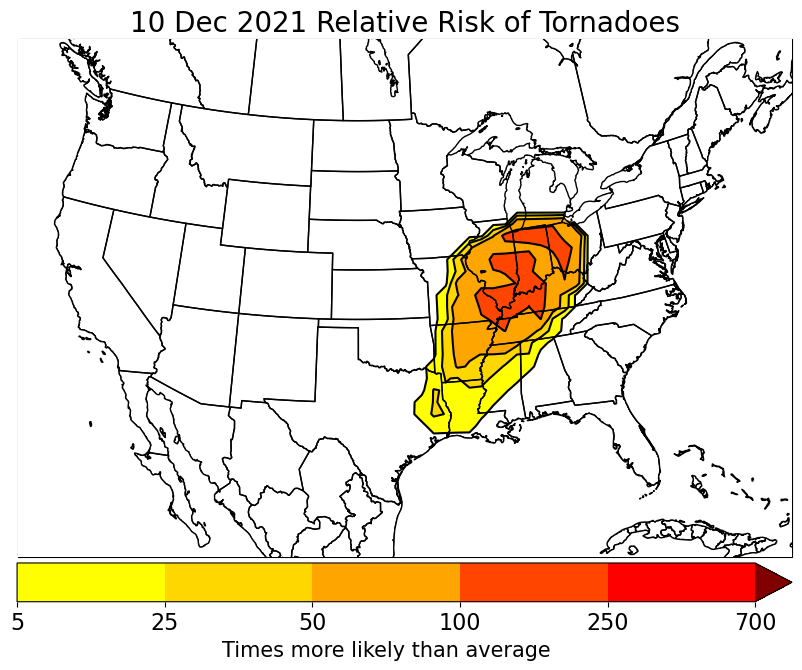

In [8]:
fig, axs = plt.subplots(ncols=1, subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-100,central_latitude=39.8,
                                                                    standard_parallels=(39.8,39.8))})
date = day.strftime('%d %b %Y')
axs.set_extent([W,E,S,N], ccrs.Geodetic())
axs.coastlines(resolution='10m')
axs.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
axs.add_feature(cfeature.STATES.with_scale('10m'), zorder=99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        axs.add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=10)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        axs.add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=10)
    else:
        pass  #do not plot the geometry     

col2=colors.ListedColormap(["yellow","gold","orange","orangered","red","maroon"])
vrel = [5,25,50,100,250,700,2000]
norm = colors.BoundaryNorm(vrel, col2.N)
    
plt.contour(XX,YY,FcstNormRisk,levels=vrel[0:6], colors="black", norm = norm,zorder = 1)
plt.contourf(XX,YY,FcstNormRisk, cmap=col2, vmin=0, levels=vrel[0:6], norm = norm, extend = "max",zorder = 0)
cbar2=plt.colorbar(ticks = vrel[0:6], orientation='horizontal', ax = axs, pad=0.01)
cbar2.ax.tick_params(labelsize=16)
cbar2.set_label('Times more likely than average', size = 15)
axs.set_title('{} Relative Risk of Tornadoes'.format(date),size=20)
#axs.set_title('Relative Risk of Tornadoes\nMaximum Value: {}'.format(int(np.max(FcstNormRisk))),size=20)


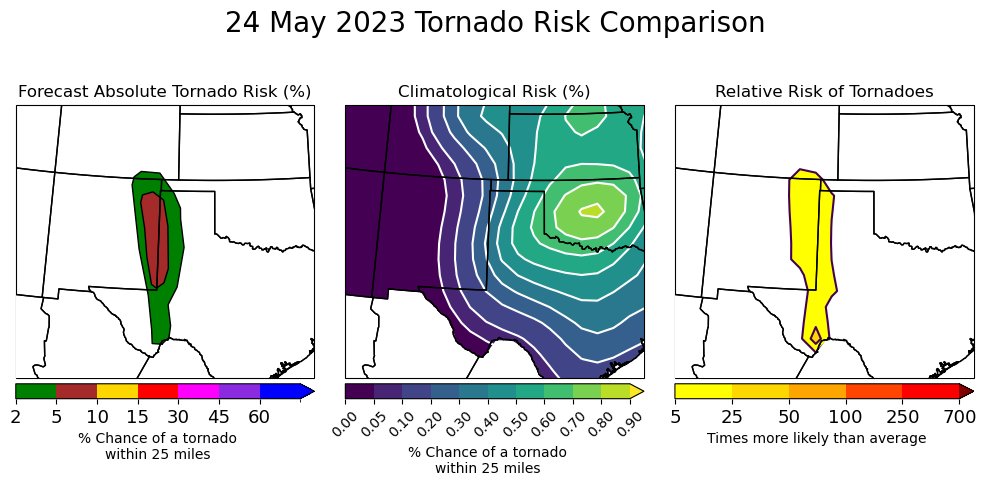

In [6]:
#Absolute vs Climo vs Relative plots for SPC forecast-based relative risk - horizontal separation, lat-lon zoom

#IEM Data forecast SPC outlook generator - also exports shapefiles ============================================
Xday = r"#OUTLOOK FILE DIRECTORY#\outlooks_201905201500_201905201700\outlooks_201905201500_201905201700.shp"

issuetimeX = "201905201630" #YEARMONTHDAYZTIME

#SETS BOUNDS OF PLOT, MANUAL EDIT ===========================================================================
year= 2019
month= 5
pday= 20

SPCoutlook = gpd.read_file(Xday)
issuetime = issuetimeX
#CONUS
#W, E, N, S, TitleHeight = -121.04, -73.1, 51.3, 20.5, 0.6
#Zoomed View
W, E, N, S, TitleHeight = -110, -95, 40, 28, 0.7
final = False

#Automatic code - no edits! =========================================================================================
day=datetime.datetime(year, month, pday, 12, 0)
dayofyear = day.timetuple().tm_yday
DayClim = DailyClimo.sel(day=dayofyear).smooth_torprobs * 100

#Code for stripping SPC outlook shapefiles from IEM download and creating norm risk
#Get files at https://mesonet.agron.iastate.edu/request/gis/spc_outlooks.phtml
SPC2 = SPCoutlook[(SPCoutlook['THRESHOLD'] == '0.02') & (SPCoutlook['CATEGORY'] == 'TORNADO') & (SPCoutlook['ISSUE'] == issuetime)]
SPC5 = SPCoutlook[(SPCoutlook['THRESHOLD'] == '0.05') & (SPCoutlook['CATEGORY'] == 'TORNADO') & (SPCoutlook['ISSUE'] == issuetime)]
SPC10 = SPCoutlook[(SPCoutlook['THRESHOLD'] == '0.10') & (SPCoutlook['CATEGORY'] == 'TORNADO') & (SPCoutlook['ISSUE'] == issuetime)]
SPC15 = SPCoutlook[(SPCoutlook['THRESHOLD'] == '0.15') & (SPCoutlook['CATEGORY'] == 'TORNADO') & (SPCoutlook['ISSUE'] == issuetime)]
SPC30 = SPCoutlook[(SPCoutlook['THRESHOLD'] == '0.30') & (SPCoutlook['CATEGORY'] == 'TORNADO') & (SPCoutlook['ISSUE'] == issuetime)]
SPC45 = SPCoutlook[(SPCoutlook['THRESHOLD'] == '0.45') & (SPCoutlook['CATEGORY'] == 'TORNADO') & (SPCoutlook['ISSUE'] == issuetime)]
SPC60 = SPCoutlook[(SPCoutlook['THRESHOLD'] == '0.60') & (SPCoutlook['CATEGORY'] == 'TORNADO') & (SPCoutlook['ISSUE'] == issuetime)]

SPCSHPS = np.array([SPC2,SPC5,SPC10,SPC15,SPC30,SPC45,SPC60], dtype = object)
SPCvals = np.array([2.,5.,10.,15.,30.,45.,60.])

#Converts shapefile to LCC coords that match coords of dataset
xmin, ymin = ax_lcc.projection.transform_point(-121.04, 20.5,ccrs.Geodetic())
xmax, ymax = ax_lcc.projection.transform_point(-59.80, 48.30,ccrs.Geodetic())
dx = dy = 80*1000.
xaxis = np.arange(xmin, xmax+1, dx).tolist()
yaxis = np.arange(ymin, ymax+1, dy).tolist()

#loops for values
for a in range(len(SPCSHPS)):
    if SPCSHPS[a].is_empty.empty == True: pass
    else: 
        if SPCvals[a] == 2.:
            ARR = SPCSHPS[a]
            Cont = ARR['geometry'].to_crs({'proj': 'lcc', 'lat_1': 39.8, 'lat_2': 39.8, 'lat_0': 39.8, 'lon_0': -100, 'x_0': 0, 'y_0': 0,
                      'datum': 'WGS84', 'units': 'm', 'no_defs': True})
            OTLK = regionmask.mask_3D_geopandas(Cont, xaxis, yaxis, wrap_lon = False).squeeze('region')
            OTLK = OTLK.where(OTLK == False, SPCvals[a])
        else:
            ARR = SPCSHPS[a]
            Cont = ARR['geometry'].to_crs({'proj': 'lcc', 'lat_1': 39.8, 'lat_2': 39.8, 'lat_0': 39.8, 'lon_0': -100, 'x_0': 0, 'y_0': 0,
                        'datum': 'WGS84', 'units': 'm', 'no_defs': True})
            mask = regionmask.mask_3D_geopandas(Cont, xaxis, yaxis, wrap_lon = False).squeeze('region')
            OTLK = OTLK.where(mask == False, SPCvals[a])

FcstNormRisk = (OTLK / DayClim)

#Plotting norm risk with abs risk
fig, axs = plt.subplots(ncols=3, subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-100,central_latitude=39.8,
                                                                    standard_parallels=(39.8,39.8))})

#AX1=======================================================================================
date = day.strftime('%d %b %Y')
fig.suptitle('{} Tornado Risk Comparison'.format(date), size = 20, y = TitleHeight)
axs[0].set_extent([W,E,S,N], ccrs.Geodetic())
axs[0].coastlines(resolution='10m')
axs[0].add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
axs[0].add_feature(cfeature.STATES.with_scale('10m'), zorder=99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        axs[0].add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=10)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        axs[0].add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=10)
    else:
        pass  #do not plot the geometry    

col1=colors.ListedColormap(["green","brown","gold","red","fuchsia","blueviolet","blue"])
SPCcolors=np.array(["green","brown","gold","red","fuchsia","blueviolet","blue"])
vabs = [2,5,10,15,30,45,60,70]
norm = colors.BoundaryNorm(vabs, col1.N)

for a in range(len(SPCSHPS)):
    if SPCSHPS[a].is_empty.empty == True: pass
    else:
        ARR = SPCSHPS[a]
        ARR = ARR['geometry'].to_crs({'proj': 'lcc', 'lat_1': 39.8, 'lat_2': 39.8, 'lat_0': 39.8, 'lon_0': -100, 'x_0': 0, 'y_0': 0,
                      'datum': 'WGS84', 'units': 'm', 'no_defs': True})
        ARR.plot(ax=axs[0], color=SPCcolors[a], edgecolor="black")

cbar1=fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=col1), ticks = vabs[0:7], orientation='horizontal', ax = axs[0], extend = 'max', pad=0.01)
cbar1.set_label('% Chance of a tornado\nwithin 25 miles', size = 10)
cbar1.ax.tick_params(labelsize=13)
axs[0].set_title('Forecast Absolute Tornado Risk (%)',size=12)

#AX2===================================================================================================
axs[1].set_extent([W, E, S, N], ccrs.Geodetic())
axs[1].coastlines(resolution='10m')
axs[1].add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
axs[1].add_feature(cfeature.STATES.with_scale('10m'), zorder = 99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        axs[1].add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=50)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        axs[1].add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    else:
        pass  #do not plot the geometry    

#Plot data
col=plt.cm.viridis
v = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
norm = colors.BoundaryNorm(v, col.N)

axs[1].contour(XX,YY,(DayClim),colors = "white", levels=v[1:11], norm = norm)
CLI = axs[1].contourf(XX,YY,(DayClim),cmap=col,vmin=0,vmax=0.9, extend = "max",levels=v[0:11], norm = norm, zorder = 0)
cbar2=fig.colorbar(CLI, ticks = v[0:11], orientation='horizontal', ax = axs[1], pad=0.01)
cbar2.set_label('% Chance of a tornado\nwithin 25 miles', size = 10)
cbar2.ax.tick_params(labelsize=10,rotation=45)
axs[1].set_title('Climatological Risk (%)'.format(date),size=12)

#AX3 =================================================================================================
axs[2].set_extent([W,E,S,N], ccrs.Geodetic())
axs[2].coastlines(resolution='10m')
axs[2].add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
axs[2].add_feature(cfeature.STATES.with_scale('10m'), zorder=99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        axs[2].add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=10)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        axs[2].add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=10)
    else:
        pass  #do not plot the geometry    

col2=colors.ListedColormap(["yellow","gold","orange","orangered","red","maroon"])
vrel = [5,25,50,100,250,700,2000]
norm = colors.BoundaryNorm(vrel, col2.N)
    
axs[2].contour(XX,YY,FcstNormRisk,levels=vrel[0:6], norm = norm,zorder = 1)
RLC = axs[2].contourf(XX,YY,FcstNormRisk, cmap=col2,vmin=0, levels=vrel[0:6], norm = norm, extend = "max",zorder = 0)
cbar2=fig.colorbar(RLC, ticks = vrel[0:6], orientation='horizontal', pad=0.01)
cbar2.ax.tick_params(labelsize=13)
cbar2.set_label('Times more likely than average', size = 10)
axs[2].set_title('Relative Risk of Tornadoes',size=12)
#axs[2].set_title('Relative Risk of Tornadoes\nMaximum Value: {}'.format(int(np.max(FcstNormRisk))),size=12)

fig.canvas.draw()
fig.tight_layout(rect=[0, 0.1, 1, 0.95])
if final==True:
    plt.savefig('#FILE SAVE DIRECTORY#/{} FCSTThreePanelRiskPlot{}W{}E{}N{}S'.format(date,W,E,N,S), bbox_inches='tight', dpi = 500)

#Produce shapefile in LCC coords ==================================================================================================
#==================================================================================================================================
outname = ("#FILE DIRECTORY FOR SAVING FILE#/{}".format(issuetime))
if Path(outname).is_dir() == False:
    os.mkdir(outname)

lvl_lookup = dict(zip(RLC.collections, RLC.levels))
PolyList=[]

#Converts contours to shapefile polygons with one polygon per closed area
for col in RLC.collections:
    z=lvl_lookup[col] # the value of this level
    for path in col.get_paths():
        if path.to_polygons():
            for npoly, polypoints in enumerate(path.to_polygons()):
                poly_lons = polypoints[:, 0]
                poly_lats = polypoints[:, 1]
                # be careful with the following---check to make sure
                # your coordinate system expects lat first, lon second
                poly_init = geometry.Polygon([(i[0], i[1]) for i in zip(poly_lons, poly_lats)])
                if poly_init.is_valid:
                    poly_clean = poly_init
                else:
                    poly_clean = poly_init.buffer(0.)
                if npoly == 0:
                    poly = poly_clean
                else:
                    poly = poly.difference(poly_clean)
        PolyList.append({'poly':poly,'props':{'z': z}})
            
# define ESRI schema, write each polygon to the file
outfi=os.path.join(outname,'{}NormRisk.shp'.format(issuetime))
schema = {'geometry': 'Polygon','properties': {'z': 'float'}}
with fiona.collection(outfi, "w", "ESRI Shapefile", schema) as output:
    for p in PolyList:
        output.write({'properties': p['props'],
            'geometry': geometry.mapping(p['poly'])})

#Resaves shapefile in LatLon coords and as multipolygon for layers with multiple closed polygons
SPCoutlook = gpd.read_file(r"#FILE DIRECTORY FOR SAVING FILE#\{}\{}NormRisk.shp".format(issuetime, issuetime))
SPCoutlook['geometry'].crs = {'proj': 'lcc', 'lat_1': 39.8, 'lat_2': 39.8, 'lat_0': 39.8, 'lon_0': -100, 'x_0': 0, 'y_0': 0,
                      'datum': 'WGS84', 'units': 'm', 'no_defs': True}
SPCoutlook['geometry'] = SPCoutlook['geometry'].to_crs(4326)
multipol = []
Filefinal = []
polylevels = SPCoutlook['z']
polypoints = SPCoutlook['geometry']
levzero = polylevels[0]
for v in range(len(SPCoutlook['z'])):
    if polylevels[v] == levzero:
        multipol.append(polypoints[v])
    else:
        Filefinal.append({'poly':shp.geometry.MultiPolygon(multipol),'props':{'z': levzero}})
        levzero = polylevels[v]
        multipol = []
        multipol.append(polypoints[v])
Filefinal.append({'poly':shp.geometry.MultiPolygon(multipol),'props':{'z': levzero}})
outfi=os.path.join(outname,'{}NormRisk.shp'.format(issuetime))
schema = {'geometry': 'Polygon','properties': {'z': 'float'}}
with fiona.collection(outfi, "w", "ESRI Shapefile", schema) as output:
    for p in Filefinal:
        output.write({'properties': p['props'],
            'geometry': geometry.mapping(p['poly'])})


In [14]:
#Begin percentile calculations here======================================================================================
#Creates mask of the lower 48 at the same LCC grid spacing as the dataset
USbounds = regionmask.mask_geopandas(USshp, xaxis, yaxis, wrap_lon = False)

#Mask daily probabilities below a specified value:
#Consider not calculating Relative risk below X value - single report suggests below 0.08 (explore 0.02 to line with spc)
Day_grids = Day_grids.where((Day_grids.smooth_torprobs >= 0.02))
Day_gridsMa = Day_grids.where(USbounds == False)

In [7]:
Dn = RelRiskMa.RelRisks.values
a1, b1, loc1, scale1 = beta.fit(Dn[~(np.isnan(Dn))])

DRn = RelRiskMa.where(RelRiskMa.RelRisks['lon'] > -105).RelRisks.values
aR1, bR1, locR1, scaleR1 = beta.fit(DRn[~(np.isnan(DRn))])

D = Day_gridsMa.smooth_torprobs.values * 100
a2, b2, loc2, scale2 = beta.fit(D[~(np.isnan(D))])

DR = Day_gridsMa.where(Day_gridsMa.smooth_torprobs['lon'] > -105).smooth_torprobs.values * 100
aR2, bR2, locR2, scaleR2 = beta.fit(DR[~(np.isnan(DR))])

DWn = RelRiskMa.where(RelRiskMa.RelRisks['lon'] < -105).RelRisks.values

DW = Day_gridsMa.where(Day_gridsMa.smooth_torprobs['lon'] < -105).smooth_torprobs.values * 100

C:\Users\smoke\anaconda3\envs\Geo_Env\lib\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\smoke\anaconda3\envs\Geo_Env\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\smoke\anaconda3\envs\Geo_Env\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


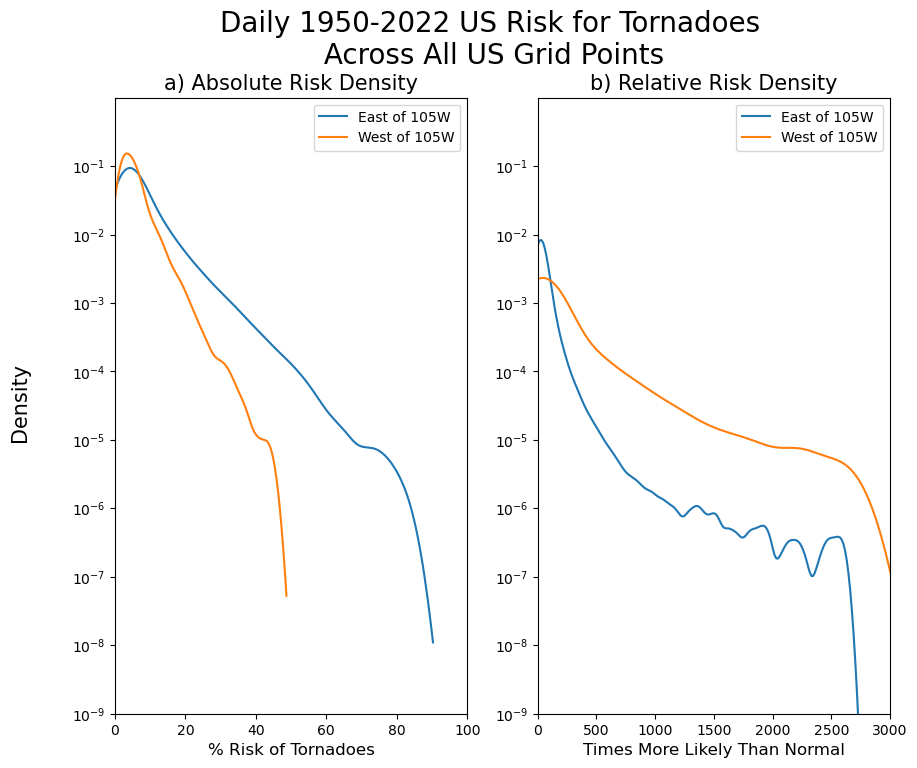

In [19]:
fig, axs = plt.subplots(1,2)
fig.suptitle('Daily 1950-2022 US Risk for Tornadoes\n Across All US Grid Points'.format(round(plat,2),round(plon,2)), size = 20, y = 0.99)
fig.supylabel("Density", size = 15)

data = DR[~(np.isnan(DR))]
sns.kdeplot(data, label = "East of 105W", ax = axs[0], bw_method = 0.5)
data = DW[~(np.isnan(DW))]
sns.kdeplot(data, label = "West of 105W", ax = axs[0], bw_method = 0.5)
axs[0].set_ylim(0.000000001,1)
axs[0].set_xlim(0,100)
axs[0].set_xlabel("% Risk of Tornadoes", size = 12)
axs[0].set_ylabel("")
axs[0].set_title('a) Absolute Risk Density',size=15)
axs[0].set_yscale("log")
axs[0].set_yticks([0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1])
axs[0].legend()

data2 = DRn[~(np.isnan(DRn))]
sns.kdeplot(data2, label = "East of 105W", ax = axs[1], bw_method = 0.5)
data2 = DWn[~(np.isnan(DWn))]
sns.kdeplot(data2, label = "West of 105W", ax = axs[1], bw_method = 0.5)
axs[1].set_ylim(0.000000001,1)
axs[1].set_xlim(0,3000)
axs[1].set_xlabel("Times More Likely Than Normal", size = 12)
axs[1].set_ylabel("")
axs[1].set_title('b) Relative Risk Density',size=15)
axs[1].set_yscale("log")
axs[1].set_yticks([0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1])
axs[1].legend()

fig.subplots_adjust(hspace=0.3)
plt.savefig('C:/Users/smoke/Documents/CRCM research/PhD Dissertation/Climo Work/Risk Plots/2Paneldensity', bbox_inches='tight')

In [10]:
#Prints percentile of SPC absolute risk values (from PPH) and the Norm risk value that corroborates with that percentile
print("2% risk", scipy.stats.percentileofscore(D[~(np.isnan(D))],2),"percentile;",
      "\nNorm Risk Value:", np.percentile(Dn[~(np.isnan(Dn))],scipy.stats.percentileofscore(D[~(np.isnan(D))],2)))
print("5% risk", scipy.stats.percentileofscore(D[~(np.isnan(D))],5),"percentile;",
      "\nNorm Risk Value:", np.percentile(Dn[~(np.isnan(Dn))],scipy.stats.percentileofscore(D[~(np.isnan(D))],5)))
print("10% risk", scipy.stats.percentileofscore(D[~(np.isnan(D))],10),"percentile;",
      "\nNorm Risk Value:", np.percentile(Dn[~(np.isnan(Dn))],scipy.stats.percentileofscore(D[~(np.isnan(D))],10)))
print("15% risk", scipy.stats.percentileofscore(D[~(np.isnan(D))],15),"percentile;",
      "\nNorm Risk Value:", np.percentile(Dn[~(np.isnan(Dn))],scipy.stats.percentileofscore(D[~(np.isnan(D))],15)))
print("30% risk", scipy.stats.percentileofscore(D[~(np.isnan(D))],30),"percentile;",
      "\nNorm Risk Value:", np.percentile(Dn[~(np.isnan(Dn))],scipy.stats.percentileofscore(D[~(np.isnan(D))],30)))
print("45% risk", scipy.stats.percentileofscore(D[~(np.isnan(D))],45),"percentile;",
      "\nNorm Risk Value:", np.percentile(Dn[~(np.isnan(Dn))],scipy.stats.percentileofscore(D[~(np.isnan(D))],45)))
print("60% risk", scipy.stats.percentileofscore(D[~(np.isnan(D))],60),"percentile;",
      "\nNorm Risk Value:", np.percentile(Dn[~(np.isnan(Dn))],scipy.stats.percentileofscore(D[~(np.isnan(D))],60)))

print("")
print("2% risk E US", scipy.stats.percentileofscore(DR[~(np.isnan(DR))],2),"percentile",
      "\nNorm Risk Value:", np.percentile(DRn[~(np.isnan(DRn))],scipy.stats.percentileofscore(DR[~(np.isnan(DR))],2)))
print("5% risk E US", scipy.stats.percentileofscore(DR[~(np.isnan(DR))],5),"percentile",
      "\nNorm Risk Value:", np.percentile(DRn[~(np.isnan(DRn))],scipy.stats.percentileofscore(DR[~(np.isnan(DR))],5)))
print("10% risk E US", scipy.stats.percentileofscore(DR[~(np.isnan(DR))],10),"percentile",
      "\nNorm Risk Value:", np.percentile(DRn[~(np.isnan(DRn))],scipy.stats.percentileofscore(DR[~(np.isnan(DR))],10)))
print("15% risk E US", scipy.stats.percentileofscore(DR[~(np.isnan(DR))],15),"percentile",
      "\nNorm Risk Value:", np.percentile(DRn[~(np.isnan(DRn))],scipy.stats.percentileofscore(DR[~(np.isnan(DR))],15)))
print("30% risk E US", scipy.stats.percentileofscore(DR[~(np.isnan(DR))],30),"percentile",
      "\nNorm Risk Value:", np.percentile(DRn[~(np.isnan(DRn))],scipy.stats.percentileofscore(DR[~(np.isnan(DR))],30)))
print("45% risk E US", scipy.stats.percentileofscore(DR[~(np.isnan(DR))],45),"percentile",
      "\nNorm Risk Value:", np.percentile(DRn[~(np.isnan(DRn))],scipy.stats.percentileofscore(DR[~(np.isnan(DR))],45)))
print("60% risk E US", scipy.stats.percentileofscore(DR[~(np.isnan(DR))],60),"percentile",
      "\nNorm Risk Value:", np.percentile(DRn[~(np.isnan(DRn))],scipy.stats.percentileofscore(DR[~(np.isnan(DR))],60)))



2% risk 0.0 percentile; 
Norm Risk Value: 2.349110226657905
5% risk 54.56081973274178 percentile; 
Norm Risk Value: 28.956674828291273
10% risk 84.90049398571695 percentile; 
Norm Risk Value: 78.78526804361657
15% risk 93.36107659419504 percentile; 
Norm Risk Value: 149.50491968727923
30% risk 99.05094696811749 percentile; 
Norm Risk Value: 644.1076656069193
45% risk 99.86128369569145 percentile; 
Norm Risk Value: 1749.1959797398817
60% risk 99.9827647076811 percentile; 
Norm Risk Value: 2562.5913815479885

2% risk E US 0.0 percentile 
Norm Risk Value: 2.349110226657905
5% risk E US 52.74609958190299 percentile 
Norm Risk Value: 26.760967261219243
10% risk E US 83.35424370123442 percentile 
Norm Risk Value: 65.18573634602299
15% risk E US 92.44081924504192 percentile 
Norm Risk Value: 106.97667391608312
30% risk E US 98.88308842271826 percentile 
Norm Risk Value: 287.9592100059855
45% risk E US 99.83481361082882 percentile 
Norm Risk Value: 713.2184347790165
60% risk E US 99.9794758394

In [15]:
#Prints percentiles for the two Relative Risk distributions
print("1% percentile Full US Relative Risk", np.percentile(Dn[~(np.isnan(Dn))],1))
print("10% percentile Full US Relative Risk", np.percentile(Dn[~(np.isnan(Dn))],10))
print("25% percentile Full US Relative Risk", np.percentile(Dn[~(np.isnan(Dn))],25))
print("50% percentile Full US Relative Risk", np.percentile(Dn[~(np.isnan(Dn))],50))
print("75% percentile Full US Relative Risk", np.percentile(Dn[~(np.isnan(Dn))],75))
print("90% percentile Full US Relative Risk", np.percentile(Dn[~(np.isnan(Dn))],90))
print("99% percentile Full US Relative Risk", np.percentile(Dn[~(np.isnan(Dn))],99))
print("")
print("1% percentile East of 105W Relative Risk", np.percentile(DRn[~(np.isnan(DRn))],1))
print("10% percentile East of 105W Relative Risk", np.percentile(DRn[~(np.isnan(DRn))],10))
print("25% percentile East of 105W Relative Risk", np.percentile(DRn[~(np.isnan(DRn))],25))
print("50% percentile East of 105W Relative Risk", np.percentile(DRn[~(np.isnan(DRn))],50))
print("75% percentile East of 105W Relative Risk", np.percentile(DRn[~(np.isnan(DRn))],75))
print("90% percentile East of 105W Relative Risk", np.percentile(DRn[~(np.isnan(DRn))],90))
print("99% percentile East of 105W Relative Risk", np.percentile(DRn[~(np.isnan(DRn))],99))

1% percentile Full US Normalized Risk 4.207941300343724
10% percentile Full US Normalized Risk 7.828279069598617
25% percentile Full US Normalized Risk 13.36288947720527
50% percentile Full US Normalized Risk 25.84687334378818
75% percentile Full US Normalized Risk 52.18667802073353
90% percentile Full US Normalized Risk 108.48342980101785
99% percentile Full US Normalized Risk 621.9734172961754

1% percentile East of 105W Normalized Risk 4.112349777779006
10% percentile East of 105W Normalized Risk 7.653575064583613
25% percentile East of 105W Normalized Risk 13.061174459814026
50% percentile East of 105W Normalized Risk 25.089032541445782
75% percentile East of 105W Normalized Risk 48.74489697643581
90% percentile East of 105W Normalized Risk 90.24156551518425
99% percentile East of 105W Normalized Risk 304.3780669248946


2707.010139317682


Text(0.5, 1.0, '1950-2022 Maximum Relative Risk of Tornadoes')

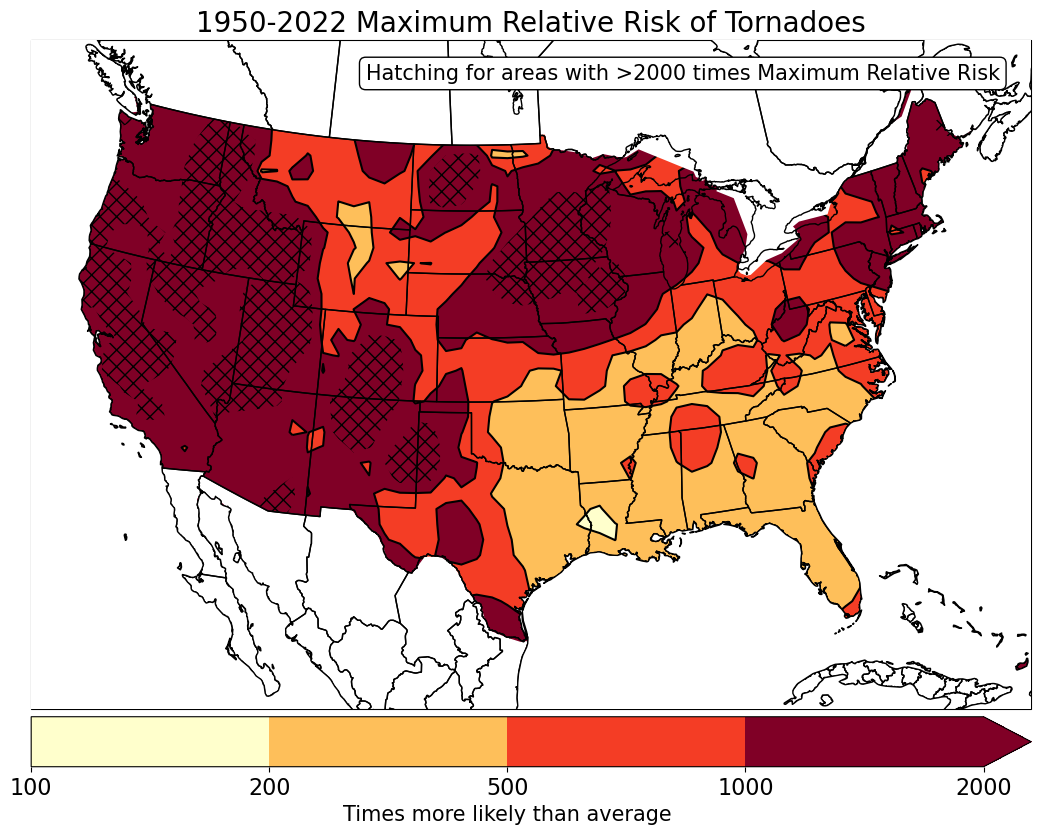

In [37]:
#Highest all time Relative risk plot
print(float(RelRisk.RelRisks.max()))

AllTimeMax = RelRisk.max(dim = ['year','day'])

MaxDat = AllTimeMax.RelRisks

fig = plt.figure()
ax_lcc = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(central_longitude=-100,central_latitude=39.8,
                                                                    standard_parallels=(39.8,39.8)))

ax_lcc.set_extent([-121.04, -73.1, 20.5, 51.3], ccrs.Geodetic())
ax_lcc.coastlines(resolution='10m')
ax_lcc.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
ax_lcc.add_feature(cfeature.STATES.with_scale('10m'), zorder = 99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        ax_lcc.add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        ax_lcc.add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    else:
        pass  #do not plot the geometry    

col=plt.cm.YlOrRd
#v = [1,10,25, 50, 75,100,250, 500, 750] #Alt vals same as normal plots
#v = [0,200,400,800,1200,1600,2000,2400,2800]
#norm = colors.BoundaryNorm(v, col.N)

v = [100,200,500,1000,2000]
norm = colors.BoundaryNorm(v, col.N)

plt.contourf(XX,YY,MaxDat, cmap=col,vmin=0, levels=v, norm = norm, extend = "max",zorder = 0)
cbar=plt.colorbar(ticks = v, orientation='horizontal', pad=0.01)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Times more likely than average', size = 15)
plt.contour(XX,YY,MaxDat,colors = "black", levels=v[0:4], norm = norm, zorder = 0)

plt.contourf(XX,YY,MaxDat, levels=[np.min(MaxDat),2000,np.max(MaxDat)], colors='none', #hatching over 2000
                hatches=[None,'xx',],
                extend='max',zorder = 0)
plt.text(
    1100000,1400000, "Hatching for areas with >2000 times Maximum Relative Risk".format(int(np.max(DayRisk))), ha="center", va="center", size=15,
    bbox=dict(boxstyle="round,pad=0.3", fc = "white"), zorder = 100)

plt.title('1950-2022 Maximum Relative Risk of Tornadoes',size=20)

114.90828293919067


Text(0.5, 1.0, '19 May 2013 to 01 Jun 2013\nMaximum Normalized Risk of Tornadoes')

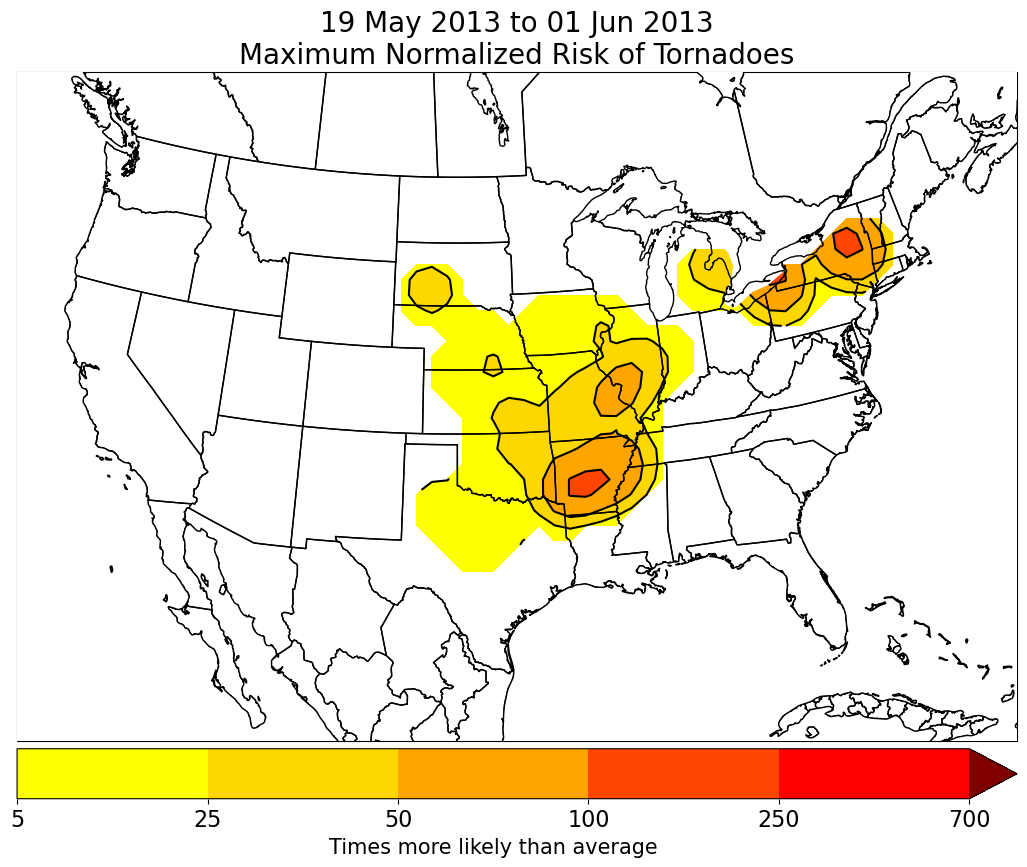

In [7]:
#Plot Maximum Relative Risk over a chosen timeframe
Year1 = 2013
Month1 = 5
Day1 = 19

Year2 = 2013
Month2 = 6
Day2 = 1

day1=datetime.datetime(Year1, Month1, Day1, 12, 0)
dayofyear1 = day1.timetuple().tm_yday
day2=datetime.datetime(Year2, Month2, Day2, 12, 0)
dayofyear2 = day2.timetuple().tm_yday

#MY EVIL GENIUS - Couldn't solve a way to break between disparate days across multiple years..
#So I slice the start and end years and the years in the middle, stack them, and find the maximum!
if (Year2 - Year1 == 0) == True:
    #For when slice is within a year:
    TimeSlice = RelRisk.where(RelRisk['year'] == Year1)
    TimeSlice = TimeSlice.where(np.bitwise_and(RelRisk['day'] >= dayofyear1, RelRisk['day'] <= dayofyear2))
    SliceMax = TimeSlice.max(dim = ['year','day']).RelRisks
    print(float(SliceMax.max()))
else:
    #For when slice is across multiple years
    Slices = []
    TimeSliceS = RelRisk.where(np.bitwise_and(RelRisk['year'] == Year1, RelRisk['day'] >= dayofyear1))
    TimeSliceM = RelRisk.where(np.bitwise_and(RelRisk['year'] > Year1, RelRisk['year'] < Year2))
    TimeSliceE = RelRisk.where(np.bitwise_and(RelRisk['year'] == Year2, RelRisk['day'] <= dayofyear2))
    Slices.append(TimeSliceS.max(dim = ['year','day']).RelRisks)
    Slices.append(TimeSliceM.max(dim = ['year','day']).RelRisks)
    Slices.append(TimeSliceE.max(dim = ['year','day']).RelRisks)
    TimeSlice = xr.Dataset(data_vars = dict(RelRisks=(["a","lat","lon"], Slices)), 
                  coords = dict(a = (["a"], np.arange(0,3)),
                                lat = (["lat"], yaxis),
                                lon = (["lon"], xaxis)
                               ))
    SliceMax = TimeSlice.max(dim = ['a']).RelRisks
    print(float(SliceMax.max()))

fig = plt.figure()
ax_lcc = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(central_longitude=-100,central_latitude=39.8,
                                                                    standard_parallels=(39.8,39.8)))

ax_lcc.set_extent([-121.04, -73.1, 20.5, 51.3], ccrs.Geodetic())
ax_lcc.coastlines(resolution='10m')
ax_lcc.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
ax_lcc.add_feature(cfeature.STATES.with_scale('10m'), zorder=99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        ax_lcc.add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        ax_lcc.add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    else:
        pass  #do not plot the geometry    

col=colors.ListedColormap(["yellow","gold","orange","orangered","red","maroon"])
v = [5,25,50,100,250,700,2000]
norm = colors.BoundaryNorm(v, col.N)

plt.contourf(XX,YY,SliceMax, cmap=col,vmin=0, levels=v[0:6], norm = norm, extend = "max",zorder = 0)
cbar=plt.colorbar(ticks = v[0:6], orientation='horizontal', pad=0.01)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Times more likely than average', size = 15)
plt.contour(XX,YY,SliceMax,colors = "black",levels=v[0:6], norm = norm,zorder = 0)

plt.title('{} to {}\nMaximum Relative Risk of Tornadoes'.format(day1.strftime('%d %b %Y'), day2.strftime('%d %b %Y')),size=20)

Text(0.5, 1.0, 'Maximum Daily Climatological Risk of Tornadoes')

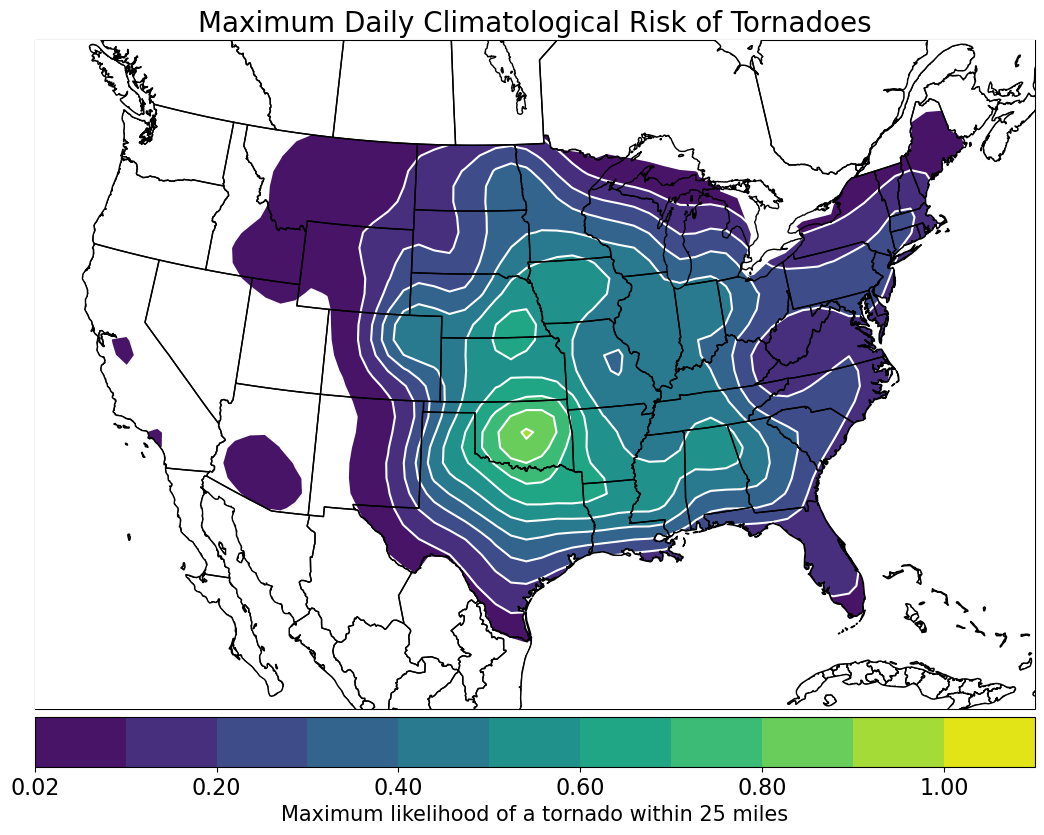

In [53]:
#what is the minimum climo day of the year across the US
AllTimeMaxCli = DailyClimo.max(dim = ['day'])

MaxCli = AllTimeMaxCli.smooth_torprobs

fig = plt.figure()
ax_lcc = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(central_longitude=-100,central_latitude=39.8,
                                                                    standard_parallels=(39.8,39.8)))

ax_lcc.set_extent([-121.04, -73.1, 20.5, 51.3], ccrs.Geodetic())
ax_lcc.coastlines(resolution='10m')
ax_lcc.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
ax_lcc.add_feature(cfeature.STATES.with_scale('10m'), zorder=99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        ax_lcc.add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        ax_lcc.add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    else:
        pass  #do not plot the geometry    

    col=plt.cm.viridis
v=[0.02,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1]

plt.contour(XX,YY,(MaxCli * 100),levels = v, colors = "white")
plt.contourf(XX,YY,(MaxCli * 100),cmap=col,vmin=0, levels=v,zorder = 0)
cbar=plt.colorbar(orientation='horizontal', pad=0.01)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Likelihood of a tornado within 25 miles', size = 15)

plt.title('Maximum Daily Climatological Risk of Tornadoes',size=20)

Text(0.5, 1.0, 'Minimum Daily Climatological Risk of Tornadoes (%)')

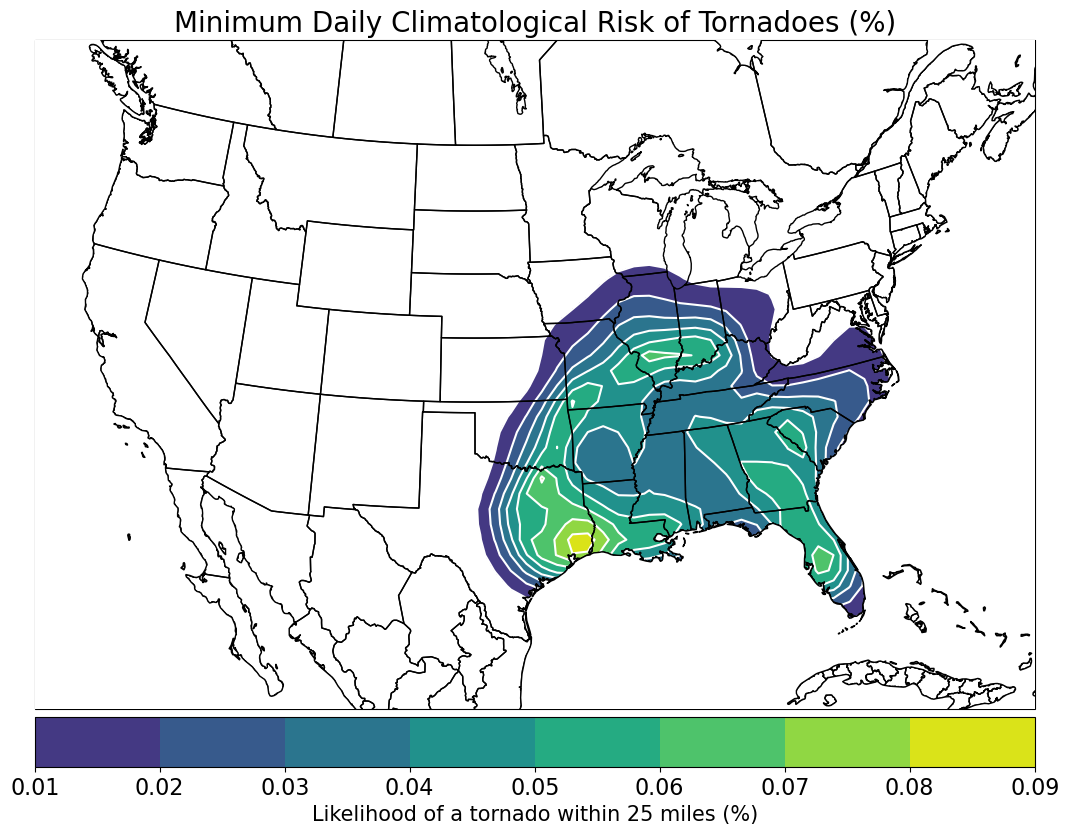

In [54]:
#what is the minimum climo day of the year across the US
AllTimeMinCli = DailyClimo.min(dim = ['day'])

MinCli = AllTimeMinCli.smooth_torprobs

fig = plt.figure()
ax_lcc = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(central_longitude=-100,central_latitude=39.8,
                                                                    standard_parallels=(39.8,39.8)))

ax_lcc.set_extent([-121.04, -73.1, 20.5, 51.3], ccrs.Geodetic())
ax_lcc.coastlines(resolution='10m')
ax_lcc.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
ax_lcc.add_feature(cfeature.STATES.with_scale('10m'), zorder=99)

#Mask non-US countries
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
areas = []

for country in countries: #creates list of polygons for non-US countries
    if country.attributes['ADM0_A3'] != 'USA':
        areas.append(country.geometry)
for area in areas:        
    if area.geom_type=='MultiPolygon': #Plots nations with multiple polygons (e.g. Canada, UK)
        ax_lcc.add_geometries(area, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    elif area.geom_type=='Polygon':  #Plots nations with single polygons (e.g. Mexico, Cuba)
        ax_lcc.add_geometries([area], crs=ccrs.PlateCarree(), facecolor="white", edgecolor='none', zorder=1)
    else:
        pass  #do not plot the geometry    

col=plt.cm.viridis
v=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]

plt.contour(XX,YY,(MinCli * 100),levels = v, colors = "white")
plt.contourf(XX,YY,(MinCli * 100),cmap=col,vmin=0, levels=v,zorder = 0)
cbar=plt.colorbar(orientation='horizontal', pad=0.01)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Likelihood of a tornado within 25 miles (%)', size = 15)

plt.title('Minimum Daily Climatological Risk of Tornadoes (%)',size=20)

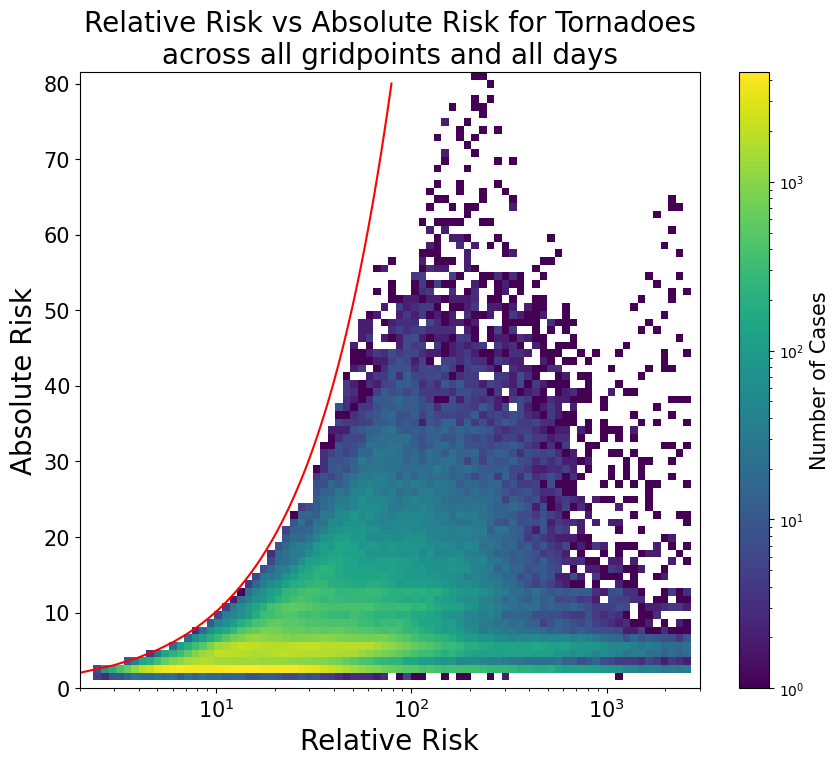

In [39]:
#KDE of absolute vs Relative risks across all gridpoints
comb = RelRiskMa.assign(smooth_torprobs = Day_grids["smooth_torprobs"])
a = comb.RelRisks.values.ravel()
x = a[~(np.isnan(a))]

b = comb.smooth_torprobs.values.ravel() * 100
y = b[~(np.isnan(a))]

x_bins = np.logspace(np.log10(np.min(x)), np.log10(np.max(x)), 80)
y_bins = np.linspace(0, np.max(y), int(np.max(y)))

H, xedges, yedges = np.histogram2d(x,y, bins = [x_bins,y_bins])
H = H.T

X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, norm=mpl.colors.LogNorm())
cbar=plt.colorbar()
plt.title('Relative Risk vs Absolute Risk for Tornadoes\nacross all gridpoints and all days',size=20)
plt.xlabel("Relative Risk", fontsize=20)
plt.ylabel("Absolute Risk", fontsize=20)
plt.xscale("log")
cbar.set_label('Number of Cases', size = 15)
plt.tick_params(axis='both', which='major', labelsize=15)
x = np.linspace(0, 80, 80)
plt.plot(x, color = "red")
plt.xlim(2,3000)

#Code for E of Rockies
#DRn = RelRiskMa.where(RelRiskMa.RelRisks['lon'] > -105)
#DR = Day_gridsMa.where(Day_gridsMa.smooth_torprobs['lon'] > -105)
#comb = DRn.assign(smooth_torprobs = DR["smooth_torprobs"])

Text(0.5, 1.0, 'April 27 2011 Gridded Tornado Reports')

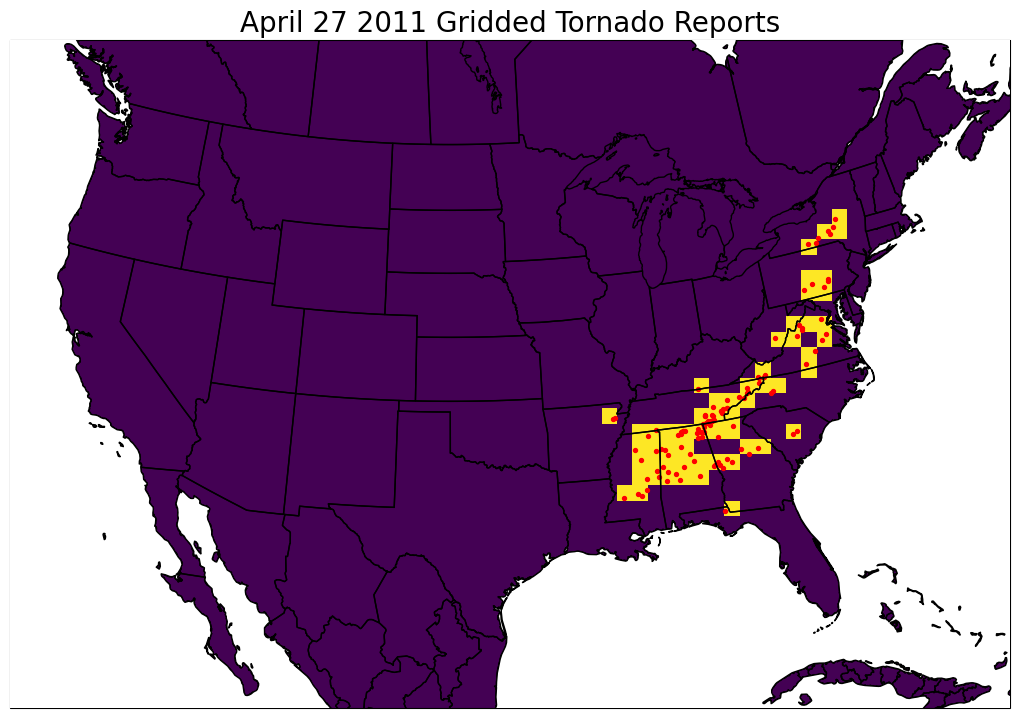

In [44]:
yeargrid = daily_grids[61]
daygrid = yeargrid[116]

lats_deg27=[]
lons_deg27=[]
year=2011
month=4
day1=27
day2=28
start_day=datetime.datetime(year, month, day1, 12, 0)
end_day=datetime.datetime(year, month, day2, 12, 0)
for k in range(len(rtime)):
        if rtime[k] >= start_day and rtime[k] <= end_day:
            lats_deg27.append(lats_deg[k])
            lons_deg27.append(lons_deg[k])
            
fig = plt.figure()
ax_lcc = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(central_longitude=-100,central_latitude=39.8,
                                                                   standard_parallels=(39.8,39.8)))

ax_lcc.set_extent([-121.04, -73.1, 20.5, 51.3], ccrs.Geodetic())
ax_lcc.coastlines(resolution='10m')
ax_lcc.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k',facecolor='w')
ax_lcc.add_feature(cfeature.STATES.with_scale('10m'))
xmin, ymin = ax_lcc.projection.transform_point(-121.04, 20.5,ccrs.Geodetic())
xmax, ymax = ax_lcc.projection.transform_point(-59.80, 48.30,ccrs.Geodetic())
dx = dy = 80*1000.

xaxis = np.arange(xmin, xmax+1, dx).tolist()
yaxis = np.arange(ymin, ymax+1, dy).tolist()
XX, YY = np.meshgrid(xaxis, yaxis)

v=np.arange(0,0.012,0.002)
plt.pcolormesh(XX,YY,daygrid)
plt.scatter(x=lons_deg27, y=lats_deg27,
            color="red",
            s = 8,
            transform=ccrs.PlateCarree()) ## Important
plt.title('April 27 2011 Gridded Tornado Reports',size=20)

In [ ]:
#Code below this point is data creation/etc, and should only be run to create spreadsheets =========















#===================================================================================================

In [22]:
#Daily tornado count - THIS CODE RUNS FOR ~10 MINUTES!!!  DO NOT RUN AGAIN IF NOT NEEDED!!! USE FILE INSTEAD ==============================
TorDate = []
TorCount = []

for n in range(len(RelRisk['year'])):
    for m in range(len(RelRisk['day'])):
        date = datetime.datetime(startyear + n, 1, 1, 12) + datetime.timedelta(days = m)
        indices = [idx for idx, val in enumerate(rtime) if ((val >= date) & (val <= date + datetime.timedelta(days = 1)))]
        datecount = np.count_nonzero(indices)
        TorCount.append(datecount)
        TorDate.append(date)

data = {'Date':TorDate, "Tornado Count":TorCount}
pd.DataFrame(data).sort_values('Date', ascending = True).to_csv('D:\Documents\Work Documents\CRCM research\PhD Dissertation\Climo work/DateTorCount.csv')


133

In [22]:
#Creates table of relative risks in descending order from the entire dataset.
#Creates lists by removing relative risk values from xarray and calculates date associated with each event.

# Adds data on tornado count per day (>=EF1)
df = pd.read_csv(r'D:\Documents\Work Documents\CRCM research\PhD Dissertation\Climo work/DateTorCount.csv', header = 0)
TorCount = df['Tornado Count'].values
TorDate = [datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in df['Date'].values]

MaxRank = []
AbsVal = []
MaxRankDate = []
TC = []

DailyMax = RelRiskMa.max(dim = ['lon','lat'])

for n in range(len(DailyMax['year'])):
    for m in range(len(DailyMax['day'])):
        date = datetime.datetime(startyear + n, 1, 1, 12, 0) + datetime.timedelta(days = m)
        MaxRankDate.append(date.strftime('%d %b %Y'))
        value = DailyMax.sel(year = (startyear + n), day = (m + 1))
        if float(value['RelRisks']) > 0:
            MaxRank.append(round(float(value['RelRisks']),2))
        else:
            MaxRank.append(float(value['RelRisks']))
        y = TorDate.index(date)
        TC.append(TorCount[y])
        YearSet = RelRiskMa.sel(year = (startyear + n), day = (m + 1))
        Point = YearSet.where(YearSet==YearSet.max(), drop = True).squeeze()
        lat = Point.coords['lat'].values
        lon = Point.coords['lon'].values
        ABS = Day_gridsMa.sel(year = (startyear + n), day = (m + 1), lat = lat, lon = lon)
        if lat.size > 0 and lon.size > 0:
            AbsVal.append(round(float(ABS['smooth_torprobs']) * 100, 2))
        else:
            AbsVal.append(0)

        
data = {'Date':MaxRankDate, 'Relative Risk':MaxRank, "Absolute Risk":AbsVal, "Tornado Count":TC}
RelRiskMaxRanked = pd.DataFrame(data).sort_values('Relative Risk', ascending = False)
RelRiskMaxRanked.to_csv(r'D:\Documents\Work Documents\CRCM research\PhD Dissertation\Climo work/RelRiskRank.csv')

                        
MaxRank = []
AbsVal = []
MaxRankDate = []
TC = []

DailyMaxR = RelRiskMa.where(RelRiskMa.RelRisks['lon'] > -105).max(dim = ['lon','lat'])
                        
for n in range(len(DailyMaxR['year'])):
    for m in range(len(DailyMaxR['day'])):
        date = datetime.datetime(startyear + n, 1, 1, 12, 0) + datetime.timedelta(days = m)
        MaxRankDate.append(date.strftime('%d %b %Y'))
        value = DailyMaxR.sel(year = (startyear + n), day = (m + 1))
        if float(value['RelRisks']) > 0:
            MaxRank.append(round(float(value['RelRisks']),2))
        else:
            MaxRank.append(float(value['RelRisks']))
        y = TorDate.index(date)
        TC.append(TorCount[y])
        YearSet = RelRiskMa.sel(year = (startyear + n), day = (m + 1))
        Point = YearSet.where(YearSet==YearSet.max(), drop = True).squeeze()
        lat = Point.coords['lat'].values
        lon = Point.coords['lon'].values
        ABS = Day_gridsMa.sel(year = (startyear + n), day = (m + 1), lat = lat, lon = lon)
        if lat.size > 0 and lon.size > 0:
            AbsVal.append(round(float(ABS['smooth_torprobs']) * 100, 2))
        else:
            AbsVal.append(0)

        
data = {'Date':MaxRankDate, 'Relative Risk':MaxRank, "Absolute Risk":AbsVal, "Tornado Count":TC}
RelRiskMaxRanked = pd.DataFrame(data).sort_values('Relative Risk', ascending = False)
RelRiskMaxRanked.to_csv(r'D:\Documents\Work Documents\CRCM research\PhD Dissertation\Climo work/RelRiskRankEastRockies.csv')

In [8]:
#Creates series of tables that rank days by the number of gridpoints above a specified value
CutoffVals = [50,100,200,500,1000,2000]

for k in range(len(CutoffVals)):
    
    TC = []
    MaxArea = []
    MaxAreaDate = []
    AreaAmt = []
    TF = RelRiskMa.RelRisks.where(RelRiskMa.RelRisks >= CutoffVals[k]).notnull()
    

    for n in range(len(TF['year'])):
        for m in range(len(TF['day'])):
            date = datetime.datetime(startyear + n, 1, 1, 12, 0) + datetime.timedelta(days = m)
            MaxAreaDate.append(date.strftime('%d %b %Y'))
            value = TF.sel(year = (startyear + n), day = (m + 1))
            counted = np.unique(value, return_counts=True)
            TrueCount = counted[1]
            y = TorDate.index(date)
            TC.append(TorCount[y])
            #This appends the # of true gridpoints if there are any, and zero if there are not.
            if len(TrueCount) == 2:
                MaxArea.append(TrueCount[1])
                AreaAmt.append(TrueCount[1]*6400)
            else:
                MaxArea.append(0)
                AreaAmt.append(0)
                
    print(CutoffVals[k], "done")
    data = {'Date':MaxAreaDate, 'Relative Risk Gridpoints':MaxArea,'Area Covered (km)':AreaAmt, "Tornado Count":TC}
    RelRiskAreaRanked = pd.DataFrame(data).sort_values('Relative Risk Gridpoints', ascending = False)
    RelRiskAreaRanked.to_csv(r"D:\Documents\Work Documents\CRCM research\PhD Dissertation\Climo work/RelRisk{}TimesAreaRank.csv'.format(CutoffVals[k]))

50 done
100 done
200 done
500 done
1000 done
2000 done


In [9]:
#Creates series of tables that rank days by the number of gridpoints above a specified value OF ABSOLUTE RISK
CutoffVals = [0.02,0.05,0.10,0.15,0.30,0.45,0.60]

for k in range(len(CutoffVals)):
    
    TC = []
    MaxArea = []
    MaxAreaDate = []
    AreaAmt = []
    TF = Day_gridsMa.smooth_torprobs.where(Day_gridsMa.smooth_torprobs >= CutoffVals[k]).notnull()
    

    for n in range(len(TF['year'])):
        for m in range(len(TF['day'])):
            date = datetime.datetime(startyear + n, 1, 1, 12, 0) + datetime.timedelta(days = m)
            MaxAreaDate.append(date.strftime('%d %b %Y'))
            value = TF.sel(year = (startyear + n), day = (m + 1))
            counted = np.unique(value, return_counts=True)
            TrueCount = counted[1]
            y = TorDate.index(date)
            TC.append(TorCount[y])
            #This appends the # of true gridpoints if there are any, and zero if there are not.
            if len(TrueCount) == 2:
                MaxArea.append(TrueCount[1])
                AreaAmt.append(TrueCount[1]*6400)
            else:
                MaxArea.append(0)
                AreaAmt.append(0)
                
    print(CutoffVals[k], "done")
    data = {'Date':MaxAreaDate, 'Absolute Risk Gridpoints':MaxArea,'Area Covered (km)':AreaAmt, "Tornado Count":TC}
    AbsRiskAreaRanked = pd.DataFrame(data).sort_values('Absolute Risk Gridpoints', ascending = False)
    AbsRiskAreaRanked.to_csv(r"D:\Documents\Work Documents\CRCM research\PhD Dissertation\Climo work/AbsRisk{}%AreaRank.csv'.format(CutoffVals[k]*100))

0.02 done
0.05 done
0.1 done
0.15 done
0.3 done
0.45 done
0.6 done
